In [36]:
from collections import defaultdict
import os
import pandas as pd
pd.options.display.float_format = '{:>5.2f}'.format
import numpy as np

import matplotlib.pyplot as plt
import json
from pprint import pprint

from scipy.ndimage.filters import gaussian_filter1d
from lifted_embedding_estimation_with_truth_value import name2lstr

In [12]:
metrics = ['mrr', 'hit1', 'hit3', 'hit10']

Conjunction_queries = ['1p', '2p', '3p', '2i', '3i', 'pi', 'ip']
Negation_queries = ['2in', '3in', 'inp', 'pin', 'pni']
Disjunction_queries = ['2u', 'up']
queries = Conjunction_queries + Disjunction_queries + Negation_queries

filter_width = .1

In [13]:
def read_log_lines(filename):
    lines = []
    with open(filename, 'rt') as f:
        for line in f.readlines():
            lines.append(line)
    return lines

def filter_lines(lines, key_str):
    rec = []
    for line in lines:
        if not key_str in line:
            continue
        json_content = json.loads(line.split(']')[-1])
        try:
            rec.append(
                json_content
            )
        except:
            print("Error in ", line)
    return rec 

In [14]:
def plot_train_lines(lines, lstr=None):
    rec = filter_lines(lines=lines, key_str="train lifted")
    if not rec:
        return
    data = defaultdict(list)
    for i, this_record in enumerate(rec):
        for k in this_record:
            data[k].append(this_record[k])
        data['id'].append(i)
    df = pd.DataFrame(data)
    
    if lstr:
        df = df[df.lstr == lstr]
        
    if len(df) > 50000:
        df = df.sample(n=50000)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 6))

    ax1.set_xlabel('steps')
    ax1.set_ylabel('truth value')
    keys = ['pos_tv', 'neg_tv', 'lifted_tv']
    for label in keys:
        if label in df.columns:
            # ax1.plot(df['id'], df[label], alpha=0.5, label=label)
            ax1.scatter(df['id'], df[label], s=1, label=label)
    # ax1.plot(df['id'], gaussian_filter1d(df['pos_tv'] - df['neg_tv'], filter_width), label='pos - neg', color='purple', alpha=0.5)
    ax1.axhline(y=0.5, color='r', linestyle='-')
    ax1.legend()
    ax1.set_ylim([0, 1])


    ax2.set_xlabel('steps')
    ax2.set_ylabel('loss')
    keys = ['loss', 'pos_tv_nll', 'neg_tv_nll', 'lifted_tv_nll', 'contrastive_nll']
    for label in keys:
        if label in df:
            # ax2.plot(df['id'], df[label], alpha=0.5, label=label)
            ax2.scatter(df['id'], df[label], s=1, label=label)
            
    ax2.legend()
    ax2.set_yscale('log')
    
    keys = ['contrastive_pos_score', 'contrastive_neg_score']
    for label in keys:
        if label in df:
            # ax3.plot(df['id'], df[label], alpha=0.5, label=label)
            ax3.scatter(df['id'], df[label], s=1, label=label)
            
    ax3.legend()
    # ax3.set_ylim([0, 1])

    ax3.set_yscale('log')
    # ax2.set_yticks([1e-2, 1e-1, 1])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


def plot_evaluation(lines, scope=['validate', 'test']):
    all_rec = filter_lines(lines=lines, key_str="NN evaluate")

    
    for k in queries:        
        if not any(k in rec for rec in all_rec): continue
        fig, axes = plt.subplots(ncols=len(scope), figsize=(3 * len(scope) + 1, 3))
        
        if len(scope) == 1:
            axes = [axes]

        for ax, desc in zip(axes, scope):
            rec = filter_lines(lines=lines, key_str=f"NN evaluate {desc}")
            if not rec: continue
            if k not in rec[0]: continue

            data = defaultdict(list)
            for i, this_record in enumerate(rec):
                for k1 in this_record[k]:
                    data[k1].append(this_record[k][k1])
                data['id'].append(i)

            df = pd.DataFrame(data)

            ax.set_xlabel('epoch')
            ax.set_ylabel('score')
            ax.set_title(f'{desc} scores for query {k}')

            for label in metrics:
                if len(df['id']) == 1:
                    ax.scatter(df['id'], df[label] * 100, label=label)
                else:
                    ax.plot(df['id'], df[label] * 100, label=label)
            ax.legend()
            # ax.set_ylim([0, 1])

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

In [34]:
def evaluation_to_tables(line, collect_metrics=metrics, verbose=True):
    data = defaultdict(list)
    for m in collect_metrics:
        data['metric'].append(m)
        for k in queries:
            if k in line:
                data[k].append(line[k][m] * 100)
        data['epoch'] = line['epoch']
    df = pd.DataFrame(data)
    try:
        df['epfo mean'] = df[Conjunction_queries + Disjunction_queries].mean(axis=1)
    except:
        pass
    try:
        df['Neg mean'] = df[Negation_queries].mean(axis=1)
    except:
        pass
    return df

def aggregate_evaluations(lines, key_str, collect_metrics=metrics, out_dir="unnamed"):
    print(key_str)
    rec_lines = filter_lines(lines, key_str)
    df_list = []
    for e, line in enumerate(rec_lines):
        df = evaluation_to_tables(line, collect_metrics)
        # print(df.to_markdown(floatfmt=".2f"))
#         df['epoch'] = (e+1) * 5
        df_list.append(df)
    if len(df_list) == 0:
        return
    final_df = pd.concat(df_list)
    final_df = final_df.set_index(['epoch', 'metric'])
    print(final_df.to_string(col_space=5))
    final_df.to_csv(os.path.join("results", out_dir, key_str + ".csv"))

In [16]:
def show_trajectory(filename, metrics=['mrr']):
    lines = read_log_lines(filename)
    plot_train_lines(lines)
    aggregate_evaluations(lines, 'CQD evaluate valid', collect_metrics=metrics)
    aggregate_evaluations(lines, 'CQD evaluate test', collect_metrics=metrics)

    
    aggregate_evaluations(lines, 'tv evaluate valid', collect_metrics=metrics)
    aggregate_evaluations(lines, 'tv evaluate test', collect_metrics=metrics)

    aggregate_evaluations(lines, 'NN evaluate valid', collect_metrics=metrics)
    aggregate_evaluations(lines, 'NN evaluate test', collect_metrics=metrics)
    # plot_evaluation(lines)

## A seminal success

In [213]:
show_trajectory('log/debug_gnn_reasoner/output.log', metrics=['mrr'])

FileNotFoundError: [Errno 2] No such file or directory: 'log/debug_gnn_reasoner/output.log'

## TV only is not good!

No handles with labels found to put in legend.


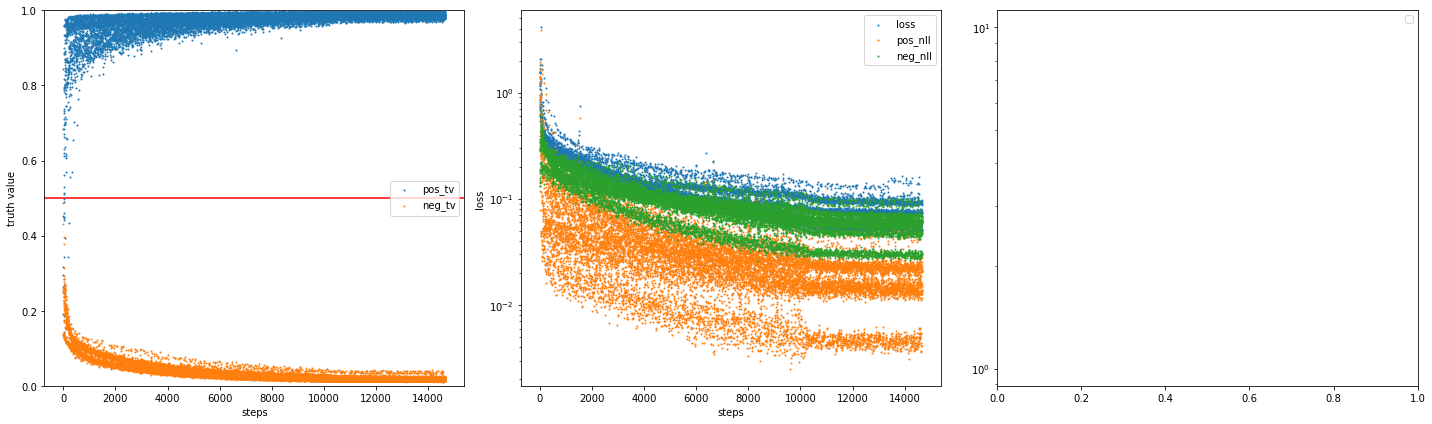

NN evaluate valid
NN evaluate test


In [8]:
"""
Interestingly, if we only optimize the pos and neg truth value given the estimated embeddings, we get bad results.
It is necessary to justify how these two objectives impacts
"""
show_trajectory('log/train_gnn_reasoner_tv/output.log', metrics=['mrr'])

## Temperature for contrastive learning is important

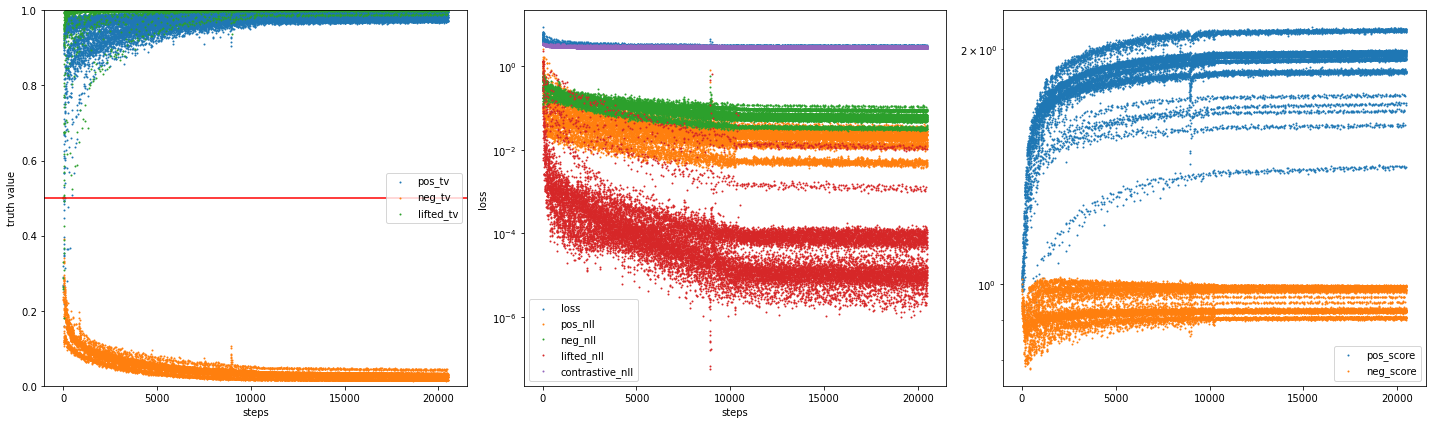

NN evaluate valid
                1p    2p    3p    2i    3i    ip    pi   2in   3in   inp   pin   pni    2u    up  epfo mean  Neg mean
epoch metric                                                                                                         
5     mrr    27.74  4.75  4.17  7.22  7.24  4.53  4.19  1.03  3.29  4.37  1.87  1.51  6.95  4.35       7.90      2.41
10    mrr    34.30  6.03  5.17 11.43 13.31  5.93  5.41  2.45  4.97  5.08  2.25  1.84  8.92  5.72      10.69      3.32
15    mrr    36.88  6.63  5.56 14.74 18.41  7.04  6.29  3.03  5.74  5.34  2.40  2.15  9.75  6.16      12.38      3.73
20    mrr    38.40  7.01  5.75 17.58 22.57  7.77  7.24  3.63  6.17  5.75  2.47  2.39 10.02  6.48      13.65      4.08
25    mrr    39.37  7.28  5.90 19.44 25.90  8.29  7.70  3.93  6.51  5.77  2.60  2.49 10.29  6.65      14.54      4.26
30    mrr    40.02  7.51  6.06 20.75 27.96  8.78  7.78  4.25  6.71  5.80  2.64  2.52 10.40  6.79      15.12      4.38
35    mrr    40.33  7.84  6.11 21.91 2

In [9]:
"""
slower implementation, since the original inner product is changed to cosine similarity to be consistent with the contrastive learning objective.
- This change causes lower scores, this can be partially explained by the derivation from the truth value scores
- Maybe we should use the inner product in the contractive loss
- Arguable whether these two methods are eventually equivalent. My idea is that these are not equivalent at all, because that we have the intermediate supervision signal on lifted 
- the temperature of the contrastive learning is very important.
"""

show_trajectory('log/train_gnn_reasoner_nn/output.log', metrics=['mrr'])

## Let's see what actually happens

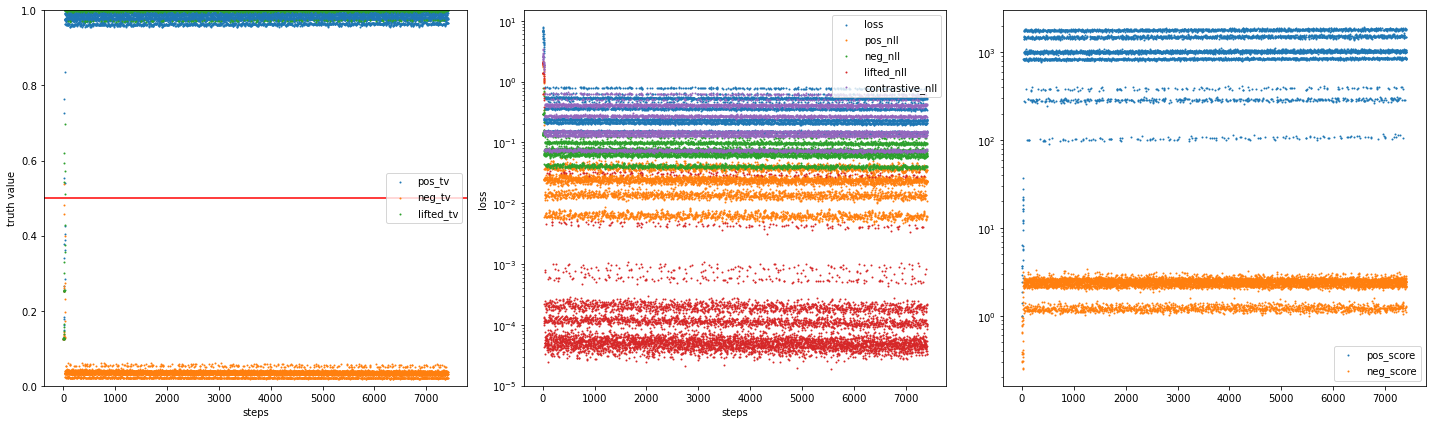

NN evaluate valid
                1p    2p    3p    2i    3i    ip    pi   2in   3in   inp   pin   pni    2u    up  epfo mean  Neg mean
epoch metric                                                                                                         
5     mrr    43.09  9.83  7.85 28.26 41.05 11.87 14.29  5.67  8.79  7.18  3.47  3.58 11.13  8.16      19.50      5.74
10    mrr    43.10  9.86  7.88 28.29 41.18 11.93 14.37  5.68  8.82  7.17  3.49  3.57 11.09  8.20      19.54      5.75
15    mrr    43.08  9.83  7.92 28.25 41.16 11.93 14.33  5.67  8.79  7.18  3.49  3.55 11.08  8.19      19.53      5.73
20    mrr    43.13  9.89  7.96 28.36 41.27 11.97 14.44  5.70  8.82  7.24  3.50  3.54 11.07  8.20      19.59      5.76
25    mrr    43.12  9.91  7.93 28.34 41.25 12.01 14.43  5.71  8.78  7.22  3.47  3.50 11.06  8.22      19.59      5.74
30    mrr    43.11  9.91  7.94 28.40 41.27 12.01 14.48  5.70  8.84  7.20  3.47  3.54 11.12  8.20      19.60      5.75
35    mrr    43.15  9.96  8.03 28.45 4

In [10]:
"""
The inner product objective is too boundless and we can get solutions that is too large.
- Seems that from the very beginning, we the performance is weaker.
- may need gridsearch about the temperature and the nbp margin.

warning: the log is corrupted. It begins with the 65-th epoch / 13-th evaluation
"""

show_trajectory('log/train_gnn_reasoner_nn_temperature=0_1/output.log', metrics=['mrr'])

## Fine tuning the link predictor

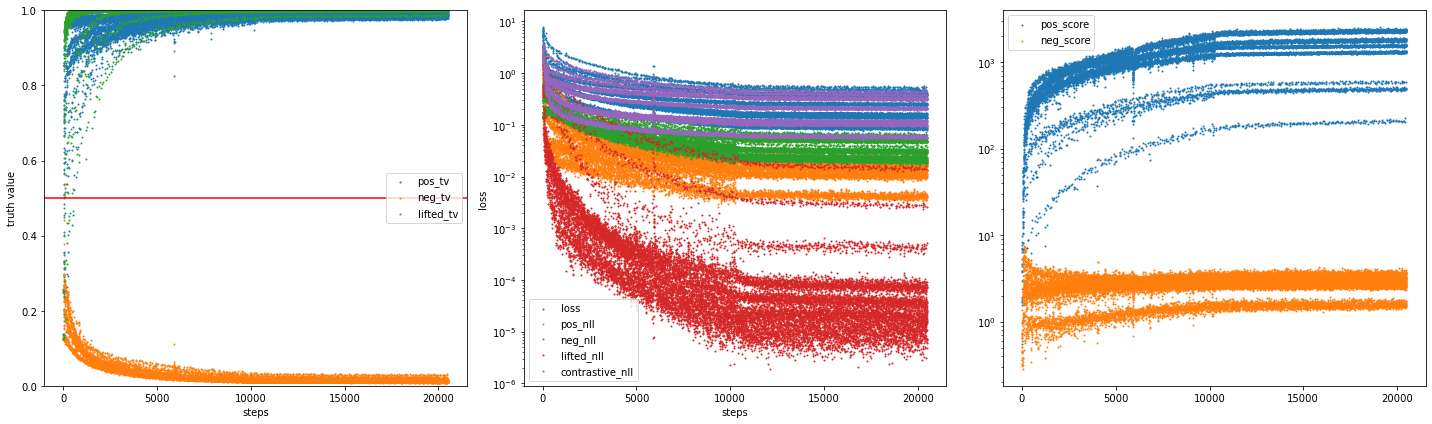

NN evaluate valid
                1p    2p    3p    2i    3i    ip    pi   2in   3in   inp   pin   pni    2u    up  epfo mean  Neg mean
epoch metric                                                                                                         
5     mrr    39.08  6.95  6.11 20.15 28.71  6.95  6.72  3.42  7.08  6.30  2.54  2.00 10.36  6.79      14.65      4.27
10    mrr    40.82  7.69  6.47 23.22 33.71  8.40  8.29  3.84  7.75  6.55  2.70  2.39 10.53  7.32      16.27      4.65
15    mrr    41.59  8.27  7.09 24.71 35.93  9.12  9.62  4.26  8.08  7.08  2.95  2.56 10.79  7.73      17.21      4.99
20    mrr    42.00  8.87  7.42 25.52 37.42 10.04 10.80  4.57  8.16  7.11  3.25  2.87 10.88  7.92      17.88      5.19
25    mrr    42.33  9.11  7.59 26.02 38.10 10.47 11.56  4.79  8.28  7.25  3.39  3.07 10.84  8.00      18.22      5.36
30    mrr    42.53  9.25  7.74 26.49 38.74 10.73 12.20  5.01  8.43  7.22  3.47  3.14 10.87  8.04      18.51      5.45
35    mrr    42.63  9.30  7.92 26.92 3

In [11]:
"""
We make the entity embedding trainable, compared to the settings with non-trainable entity embedding, we hope this can make a better contrastive loss
"""

show_trajectory('log/train_gnn_reasoner_nn_temperature=0_1_trainable_entity_embedding/output.log', metrics=['mrr'])

## Make smaller margin

margin = 0.1 temp = 0.1

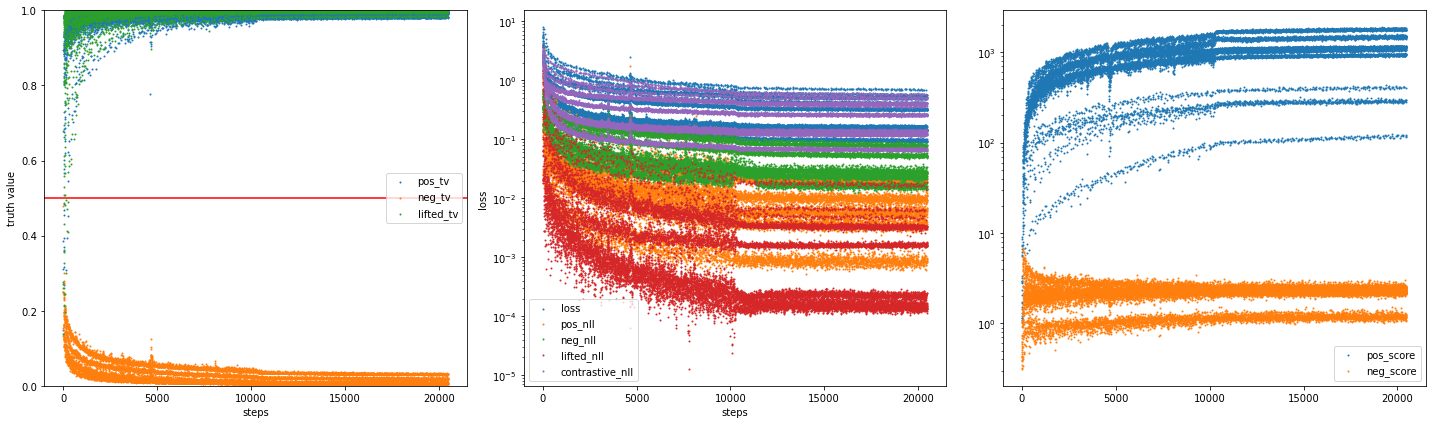

NN evaluate valid
                1p    2p    3p    2i    3i    ip    pi   2in   3in   inp   pin   pni    2u    up  epfo mean  Neg mean
epoch metric                                                                                                         
5     mrr    39.68  7.17  5.88 20.76 29.57  7.53  7.37  3.64  7.07  6.01  2.61  2.41 10.44  6.80      15.02      4.35
10    mrr    41.23  8.12  6.49 24.25 34.78  9.31  9.85  4.13  7.86  6.47  2.86  2.84 10.82  7.51      16.93      4.83
15    mrr    41.69  8.62  6.72 25.57 37.14 10.32 11.33  4.20  8.43  6.59  3.06  3.04 10.95  7.63      17.78      5.07
20    mrr    42.48  8.98  7.23 26.59 38.87 10.82 12.10  5.10  8.60  6.88  3.15  3.34 10.93  7.89      18.43      5.42
25    mrr    42.74  9.34  7.48 27.03 39.48 11.24 12.69  5.27  8.62  6.98  3.29  3.35 11.05  7.95      18.78      5.50
30    mrr    42.99  9.34  7.45 27.53 39.96 11.33 12.70  5.48  8.76  6.90  3.25  3.27 11.07  8.03      18.93      5.53
35    mrr    43.02  9.42  7.52 27.99 4

In [12]:
show_trajectory('log/train_gnn_reasoner_temp=0_1_margin=0_1/output.log', metrics=['mrr'])

In [ ]:
"""

Other improvements
1. Use different layers
2. GIN improvements?
3. Use other hyperparameters
"""

### Another suspection, will the metric be strict worse than cosine similarity?

### Of course

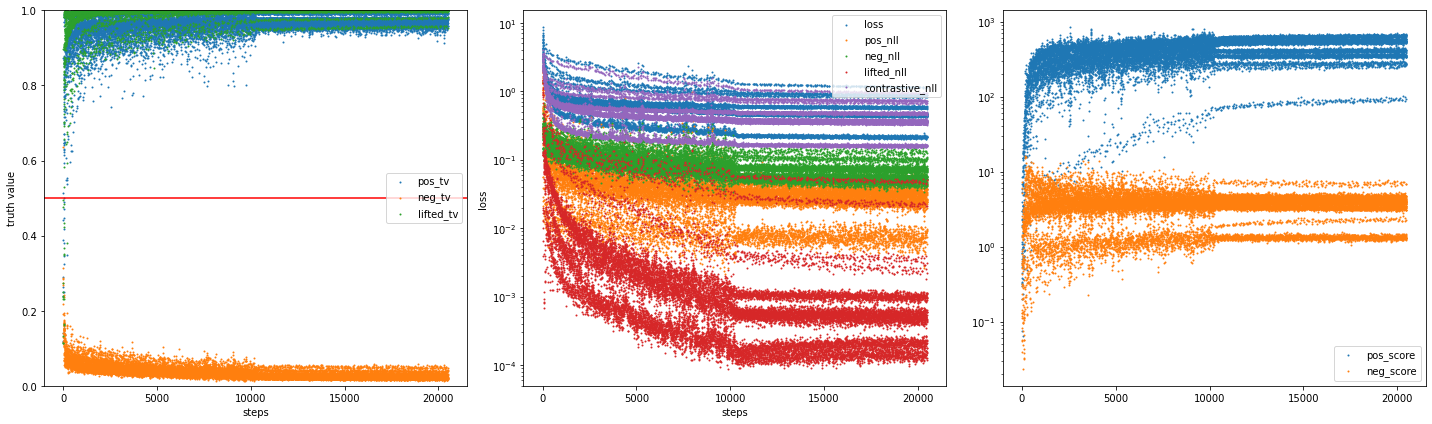

NN evaluate valid
                1p    2p    3p    2i    3i    ip    pi   2in   3in   inp   pin   pni    2u    up  epfo mean  Neg mean
epoch metric                                                                                                         
5     mrr    30.32  5.59  5.69  8.42 10.55  4.73  4.69  1.33  3.37  5.06  2.15  1.42  6.40  5.42       9.09      2.67
10    mrr    31.79  5.96  5.96 10.59 14.19  5.30  5.31  1.40  3.72  5.43  2.24  1.62  6.83  5.73      10.19      2.88
15    mrr    32.50  6.24  6.26 12.46 17.87  5.68  5.60  1.87  4.13  5.65  2.36  1.89  7.24  5.98      11.09      3.18
20    mrr    33.11  6.52  6.38 13.42 19.69  6.14  6.12  1.92  4.36  5.66  2.42  1.88  7.50  6.11      11.67      3.25
25    mrr    32.61  6.45  6.43 12.24 17.75  6.10  6.12  1.70  3.98  5.74  2.33  1.91  7.46  6.12      11.25      3.13
30    mrr    33.39  6.67  6.50 14.43 21.06  6.29  6.46  2.28  4.57  5.76  2.42  2.01  7.74  6.13      12.08      3.41
35    mrr    33.79  6.75  6.53 14.88 2

In [104]:
show_trajectory('log/train_gnn_reasoner_temp=0_1_margin=0_1_without_pretrain_cosine/output.log', metrics=['mrr'])

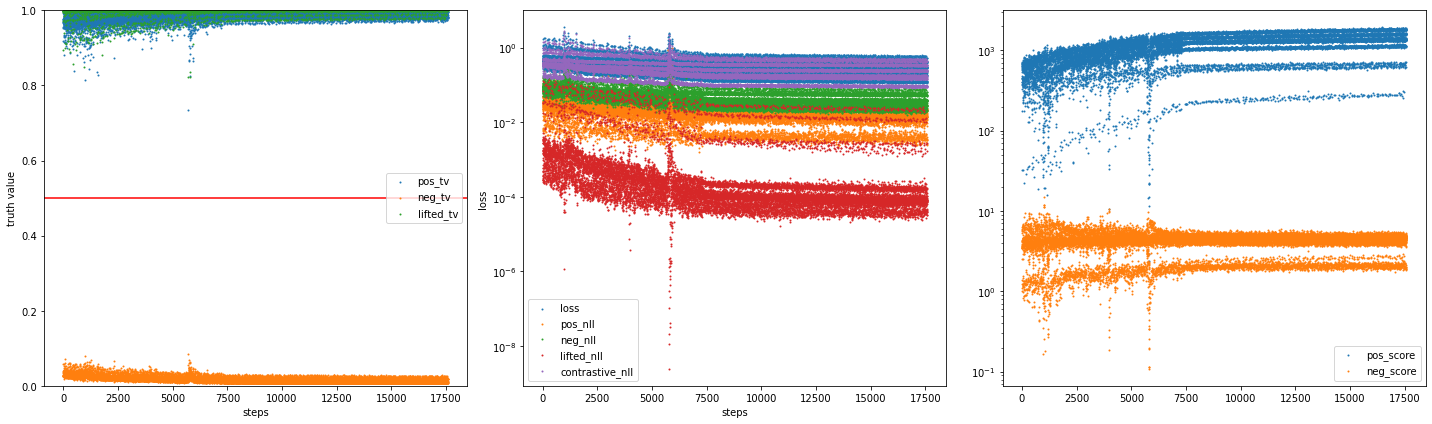

NN evaluate valid
                1p    2p    3p    2i    3i    ip    pi   2in   3in   inp   pin   pni    2u    up  epfo mean  Neg mean
epoch metric                                                                                                         
5     mrr    33.56  6.28  6.18 13.96 19.68  5.69  5.74  2.16  4.58  5.93  2.36  1.65  7.68  6.20      11.66      3.33
10    mrr    28.26  6.13  6.01 11.49 16.67  5.55  5.41  1.16  3.49  5.49  2.35  1.63  7.08  6.07      10.30      2.82
15    mrr    34.53  6.75  6.57 15.80 23.62  6.40  6.50  2.38  5.08  6.14  2.53  2.03  8.12  6.40      12.74      3.63
20    mrr    35.03  6.93  6.63 16.57 25.10  6.76  7.04  2.88  5.07  6.25  2.54  2.15  8.36  6.45      13.21      3.78
25    mrr    34.78  7.10  6.75 16.21 24.93  6.93  6.99  2.02  4.94  6.47  2.62  2.16  8.51  6.58      13.20      3.64
30    mrr    35.67  7.27  6.87 17.59 27.01  7.30  7.76  3.17  5.42  6.42  2.69  2.27  8.72  6.69      13.88      3.99
35    mrr    35.89  7.34  7.03 17.85 2

In [105]:
show_trajectory('log/train_gnn_reasoner_temp=0_1_margin=0_1_without_pretrain_cosine_joint/output.log', metrics=['mrr'])

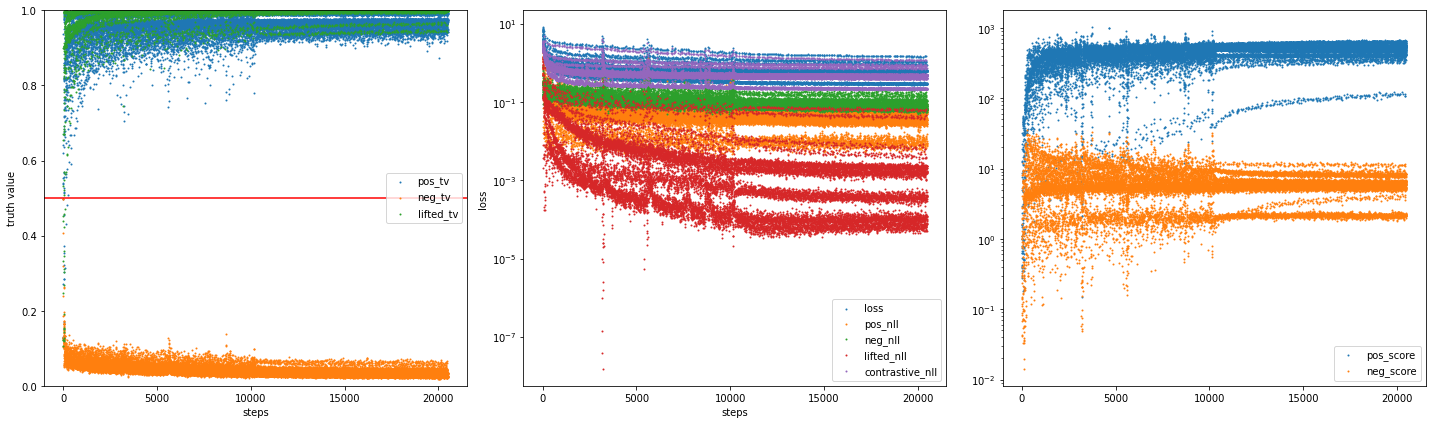

NN evaluate valid
                1p    2p    3p    2i    3i    ip    pi   2in   3in   inp   pin   pni    2u    up  epfo mean  Neg mean
epoch metric                                                                                                         
5     mrr    26.97  5.13  5.28  5.48  6.28  4.18  4.20  0.56  1.99  4.73  2.19  1.45  5.07  5.26       7.54      2.18
10    mrr    29.60  5.56  5.70  6.99  8.51  4.64  4.80  1.09  2.53  4.93  2.27  1.47  5.75  5.62       8.57      2.46
15    mrr    29.82  5.70  5.59  7.54  9.49  4.83  4.95  0.97  2.66  4.92  2.25  1.55  5.98  5.74       8.85      2.47
20    mrr    30.04  5.88  5.81  7.90 10.22  5.07  5.14  1.32  2.73  5.10  2.34  1.68  6.12  5.86       9.12      2.63
25    mrr    30.59  6.02  5.96  8.66 11.20  5.22  5.51  1.59  2.96  5.21  2.38  1.73  6.29  5.93       9.49      2.77
30    mrr    30.52  6.06  5.98  8.56 11.11  5.36  5.44  1.73  2.91  5.23  2.38  1.76  6.33  5.99       9.48      2.80
35    mrr    30.66  6.13  6.06  8.80 1

In [106]:
show_trajectory('log/train_gnn_reasoner_temp=0_1_margin=0_1_without_pretrain_cosine_pretrain100epochs/output.log', metrics=['mrr'])

# Try to report the results

## FB15k-237

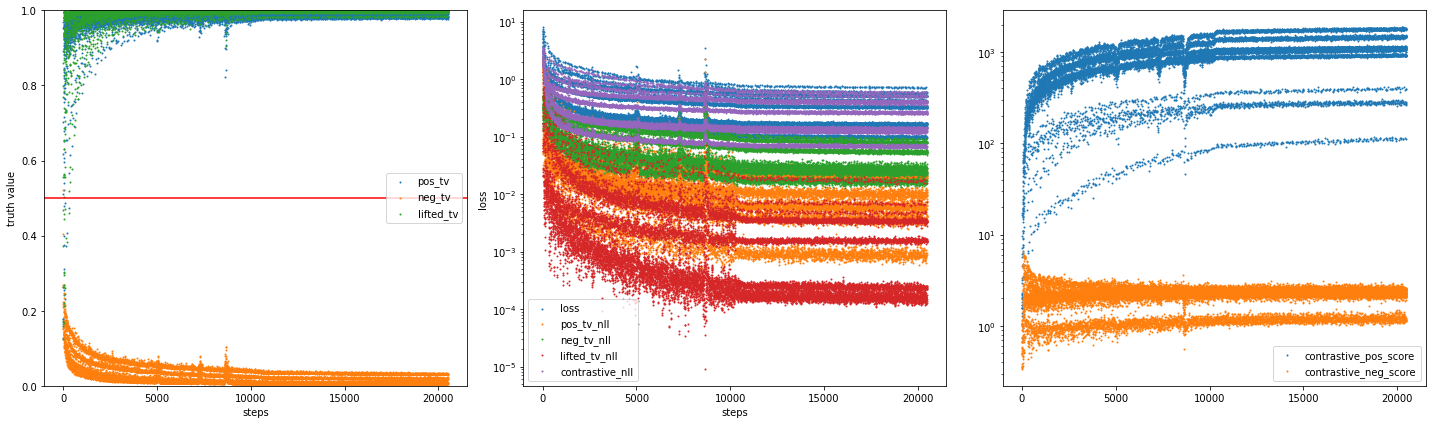

CQD evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
-1    mrr     6.30  6.44  3.86  2.84  3.10 16.90 10.92  1.08  4.18  0.03  0.02  1.81  0.11  3.71       6.18      1.14
CQD evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
-1    mrr     6.50  7.37  4.26  3.18  3.34 18.97 13.88  1.18  4.95  0.05  0.02  1.86  0.19  4.96       7.07      1.42
tv evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4

In [222]:
show_trajectory('log/fb15k-237/pretrain_complex1000-defaults/output.log', metrics=['mrr'])

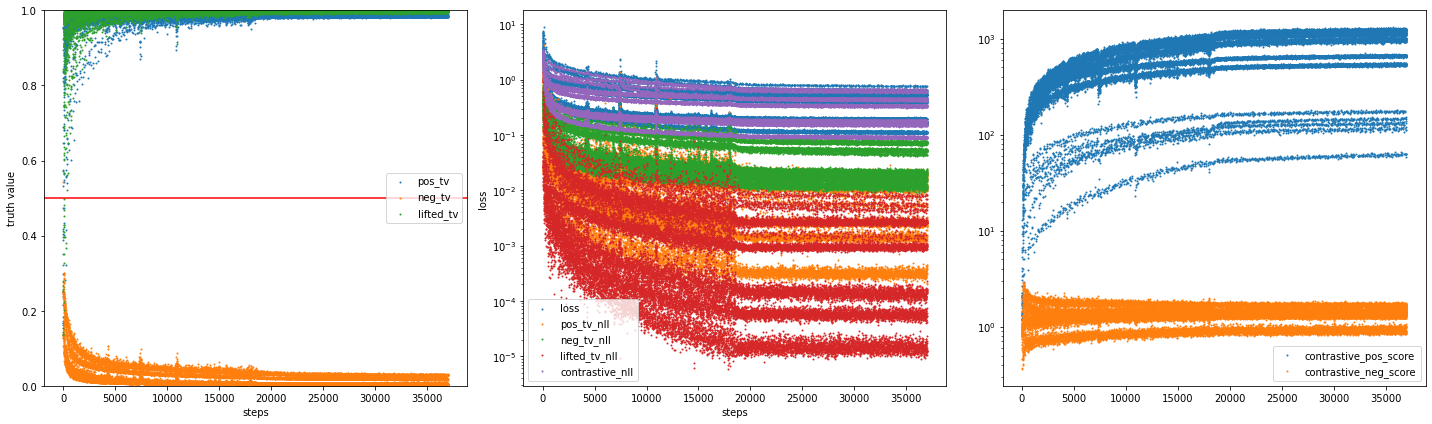

CQD evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
-1    mrr     5.43 12.45  7.05  2.43  3.00 26.18 19.36  0.79  6.75  0.03  0.01  2.33  0.12  7.55       9.27      2.01
CQD evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
-1    mrr     5.58 16.10  8.54  2.66  3.53 32.68 25.12  0.83  8.33  0.05  0.02  2.89  0.21 11.29      11.49      2.89
tv evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4

In [313]:
show_trajectory('log/fb15k/pretrain_complex1000-defaults/output.log', metrics=['mrr'])

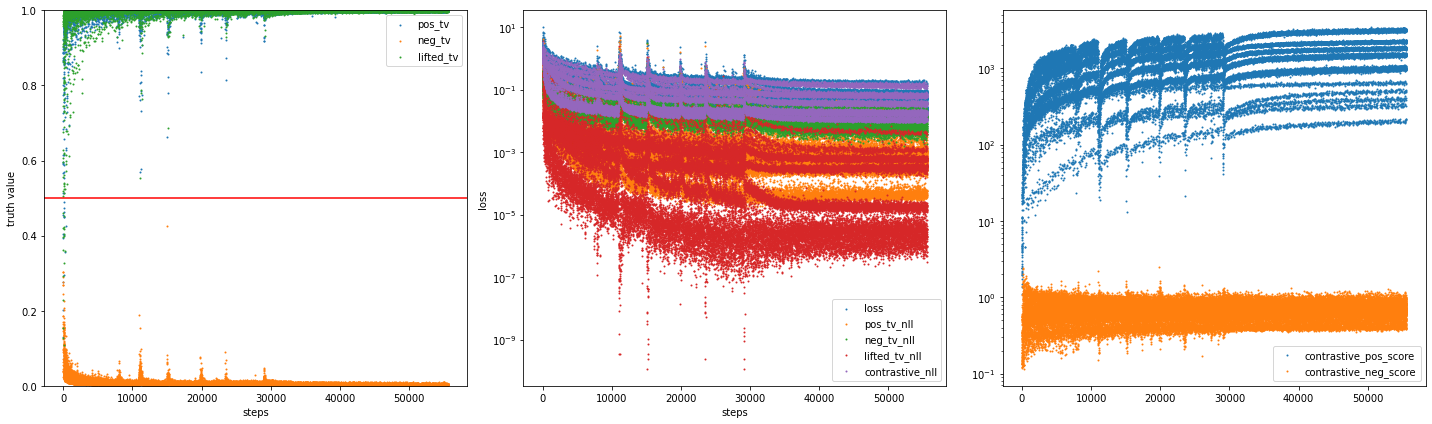

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    55.17 12.64  8.25 30.99 41.02 13.40 15.17 14.25 10.48  3.85  9.40  9.98  3.25  3.28      22.38      5.95
9     mrr    56.51 16.28 12.84 33.02 44.67 18.06 19.14 15.01 12.01  4.97  9.83 11.03  3.52  3.68      25.28      6.60
14    mrr    57.12 17.49 14.14 33.74 45.98 19.50 20.28 15.23 12.48  6.74 10.23 11.33  3.67  4.23      26.22      7.24
19    mrr    56.62 16.35 13.66 32.33 43.42 18.43 19.15 14.92 12.13  6.42  9.73 11.10  3.30  3.69      25.22      6.85
24    mrr    57.43 18.18 15.59 34.20 47.33 21.30 21.48 15.46 12.73  7.27 10.35 11.81  3.73  4.27      27.08      7.49
29    mrr    57.32 18.42 15.29 34.01 46.96 21.13 21.49 15.32 12.88  7.22 10.34 11.96

In [7]:
show_trajectory('log/nell/pretrain_complex1000-defaults/output.log', metrics=['mrr'])

## Large Negative Samples 512

/tmp/ipykernel_228490/2484068262.py:55: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()  # otherwise the right y-label is slightly clipped


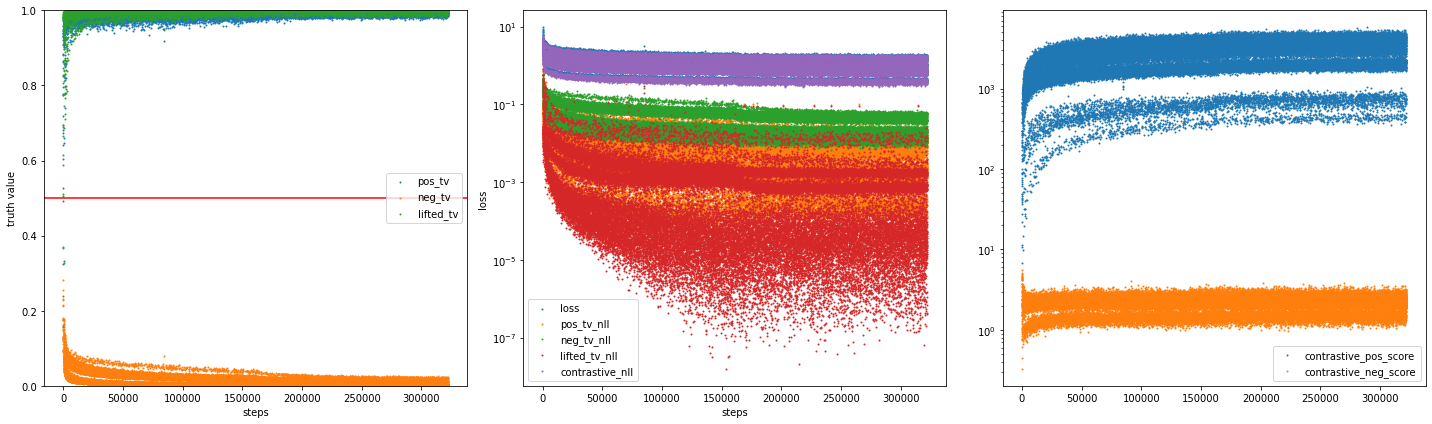

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    43.72  9.68  7.44 29.96 44.27 14.62 12.44 11.31  8.06  5.78  9.18  6.91  3.51  3.60      20.17      5.80
9     mrr    43.91 10.17  7.98 30.51 44.78 16.35 13.31 11.21  8.22  6.17  9.35  7.18  3.56  3.99      20.72      6.05
14    mrr    43.90 10.16  8.02 30.89 45.45 17.56 13.52 11.32  8.19  6.21  9.44  7.23  3.49  4.11      21.00      6.10
19    mrr    44.01 10.50  8.35 31.11 45.63 18.40 13.77 11.22  8.11  6.26  9.51  7.38  3.58  4.18      21.23      6.18
24    mrr    44.06 10.53  8.15 31.17 46.08 18.84 13.97 11.20  8.22  6.39  9.91  7.57  3.67  4.12      21.36      6.33
29    mrr    43.82 10.56  8.27 31.18 46.07 19.17 14.09 11.26  8.18  6.35  9.63  7.54

In [9]:
show_trajectory('log/fb15k-237/pretrain_complex1000-neg_sample_512/output.log', metrics=['mrr'])

## Deeper MLP (2 layers)

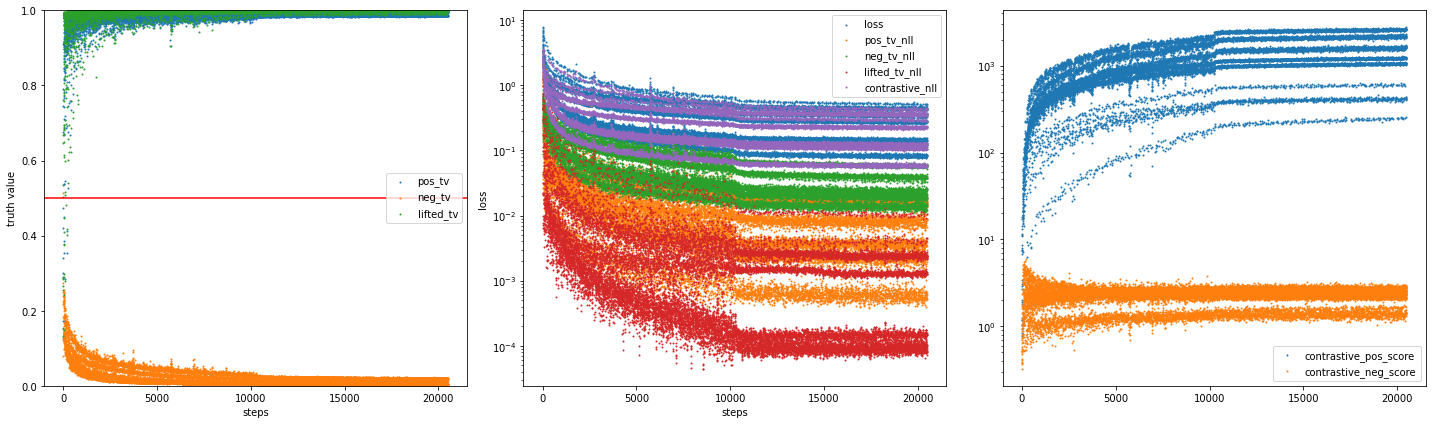

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    37.24  7.02  5.89 16.82 22.61  7.50  7.27 10.07  6.73  3.05  6.31  5.87  2.64  2.39      13.46      4.05
9     mrr    40.59  8.29  6.63 22.20 31.87 10.15  9.23 10.64  7.45  4.52  7.39  6.63  2.99  3.04      16.34      4.91
14    mrr    41.19  8.68  6.76 23.74 34.55 10.99 10.01 10.79  7.59  4.77  7.79  6.79  3.00  3.29      17.14      5.13
19    mrr    41.88  9.17  7.25 25.59 37.21 12.09 10.87 11.00  7.99  5.20  8.21  7.00  3.28  3.37      18.12      5.41
24    mrr    42.23  9.42  7.43 26.32 38.13 12.73 11.25 11.08  8.01  5.53  8.33  7.05  3.27  3.40      18.51      5.52
29    mrr    42.58  9.62  7.58 27.02 39.08 13.04 11.64 11.16  8.18  5.73  8.55  7.03

In [309]:
show_trajectory('log/fb15k-237/pretrain_complex1000-layers=2/output.log', metrics=['mrr'])

## More significant contrastive coefficient (5 times larger)

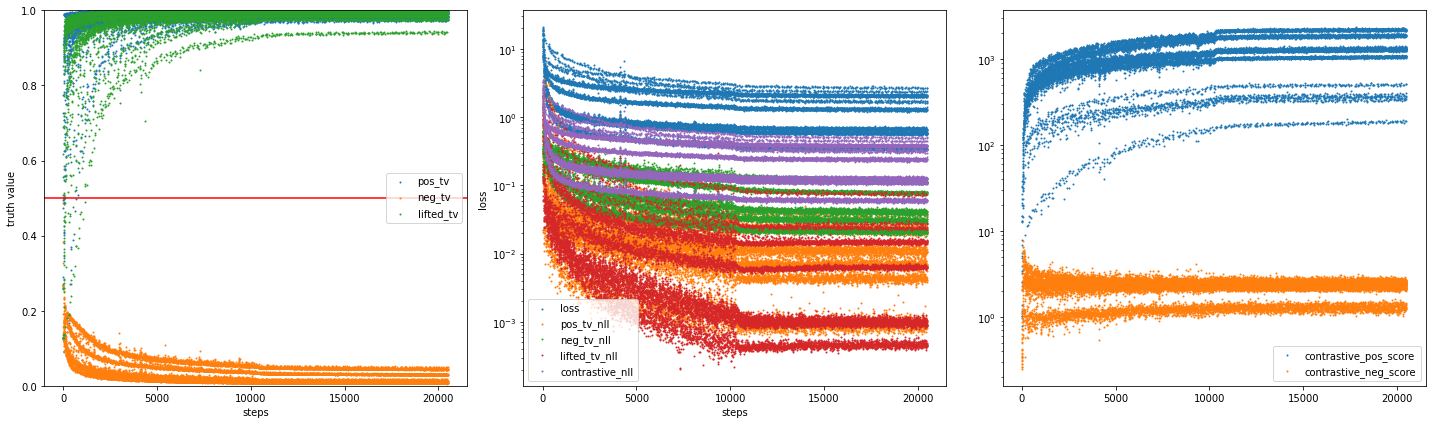

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    39.76  7.64  6.11 23.21 33.79  8.63  8.49 10.57  7.04  2.91  7.61  6.22  2.84  2.61      16.14      4.44
9     mrr    41.66  8.56  6.70 25.75 37.42 10.81 10.09 10.85  7.59  4.62  8.26  6.58  3.11  2.99      17.71      5.11
14    mrr    42.43  9.00  7.06 26.46 38.69 12.11 10.73 10.98  7.84  5.13  8.46  6.82  3.21  3.37      18.37      5.40
19    mrr    42.57  9.20  6.96 27.12 39.34 12.29 10.95 10.95  7.81  5.51  8.53  6.86  3.21  3.20      18.58      5.46
24    mrr    43.07  9.53  7.55 28.25 40.96 13.87 11.63 11.07  8.05  5.68  8.83  6.95  3.31  3.48      19.33      5.65
29    mrr    43.14  9.76  7.72 28.37 41.11 14.33 11.82 11.13  8.06  5.84  8.97  7.04

In [235]:
show_trajectory('log/fb15k-237/pretrain_complex1000-contrastive_coef=5/output.log', metrics=['mrr'])

# Gather the tricks (num_layers=2; noisy_sample_size 512; contrastive_coef=5)

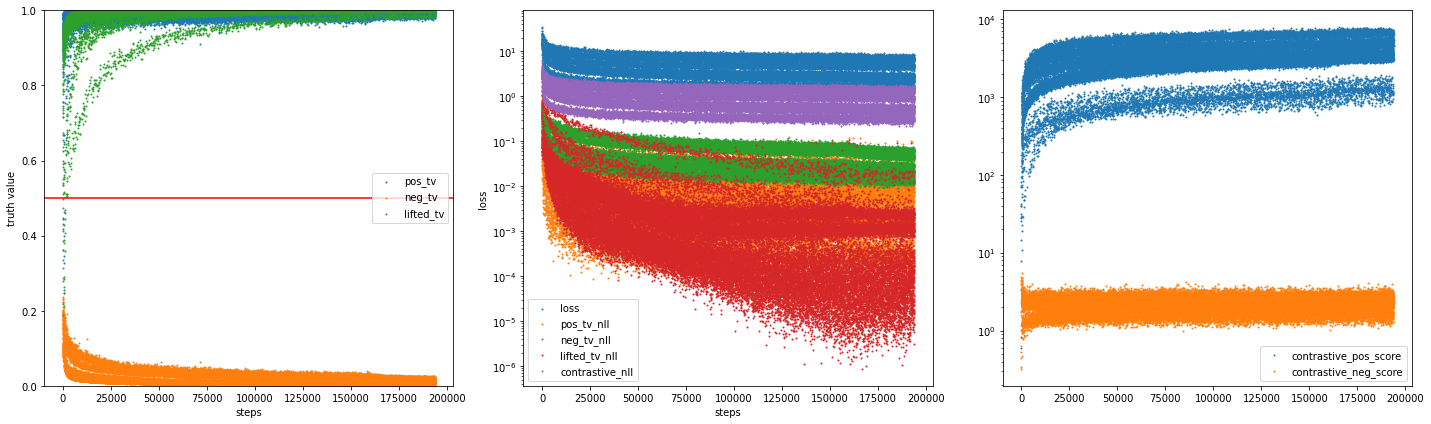

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    43.55  9.97  7.86 29.89 44.11 14.22 13.02 11.11  8.04  6.33  8.95  7.22  3.26  3.83      20.20      5.92
9     mrr    43.41 10.62  8.20 30.77 45.43 15.71 13.67 11.23  8.26  6.53  9.62  7.54  3.37  3.93      20.81      6.20
14    mrr    43.40 10.65  8.36 30.79 45.88 16.84 14.19 10.95  8.34  6.58  9.52  7.61  3.48  3.97      21.05      6.23
19    mrr    43.45 10.71  8.32 30.75 46.06 16.69 14.45 10.98  8.15  6.66  9.62  7.90  3.48  4.06      21.06      6.34
24    mrr    43.36 10.66  8.24 31.08 46.44 17.12 14.54 10.85  8.07  6.58  9.71  7.63  3.47  4.10      21.15      6.30
29    mrr    43.25 10.78  8.49 31.35 46.78 17.38 14.60 10.90  8.24  6.49  9.84  7.72

In [10]:
show_trajectory("log/fb15k-237/pretrain_complex1000-neg_sample=512_contrast_coef=5_batch_size=256_layers=2/output.log", metrics=['mrr'])

# Ablation studies
- without lift_coef = 0
- without tv_coef = 0
- without both lift_coef = tv_coef = 0

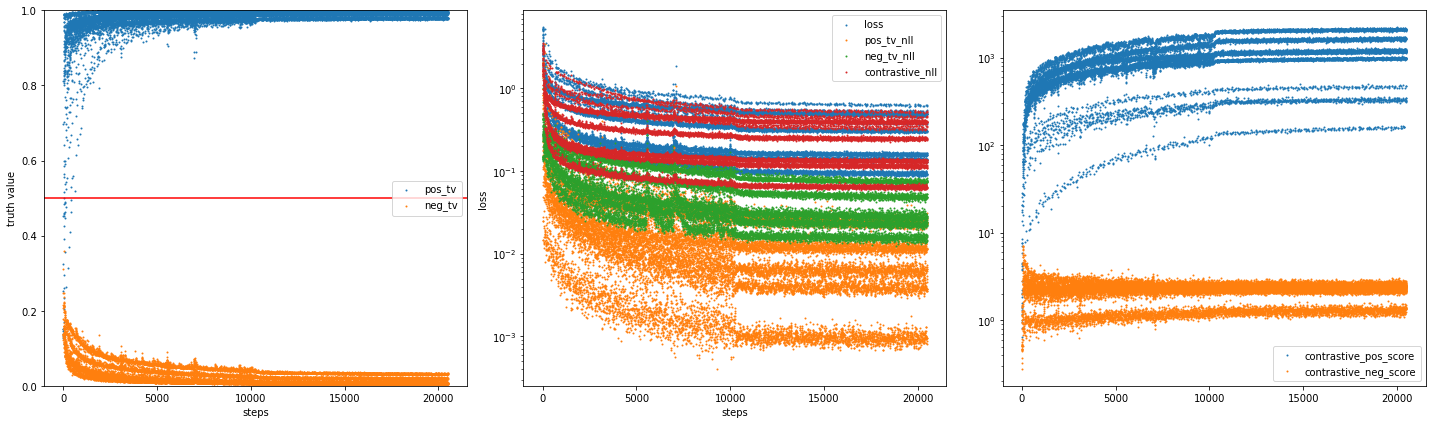

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    40.79  7.70  6.16 23.31 33.26  9.04  8.50 10.62  7.18  4.29  7.65  6.24  2.79  2.65      16.28      4.73
9     mrr    41.84  8.60  6.58 25.42 36.86 11.00  9.92 10.95  7.65  4.95  8.23  6.67  2.98  3.08      17.65      5.18
14    mrr    42.13  9.04  7.07 26.22 38.23 12.05 10.53 10.97  7.91  5.12  8.31  7.01  3.07  3.31      18.24      5.36
19    mrr    42.51  9.10  7.25 27.00 39.38 12.56 11.09 11.07  7.97  5.34  8.54  6.78  3.22  3.39      18.66      5.45
24    mrr    42.46  9.36  7.39 27.07 39.81 13.16 11.48 11.13  8.07  5.53  8.67  6.97  3.38  3.38      18.88      5.59
29    mrr    43.06  9.56  7.59 27.88 41.10 13.51 11.70 11.08  8.15  5.74  8.85  7.09

In [307]:
show_trajectory('log/fb15k-237/pretrain_complex1000-without-lift/output.log', metrics=['mrr'])

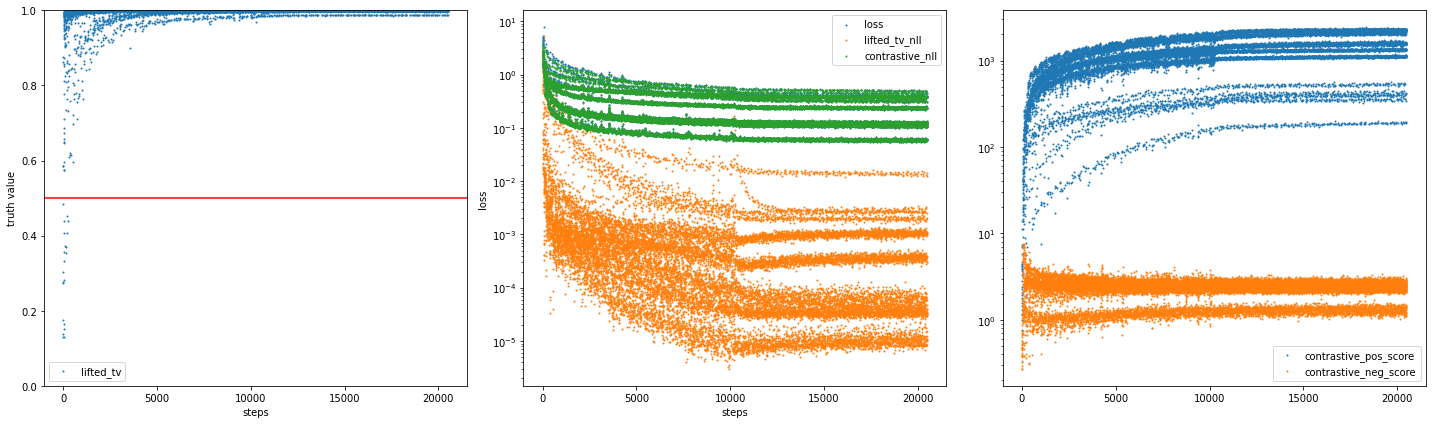

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    38.26  7.00  5.97 20.68 29.23  7.01  7.51 10.29  6.80  2.62  6.95  6.01  2.67  2.07      14.75      4.06
9     mrr    41.57  8.24  6.53 24.90 35.93  9.57  9.33 10.85  7.61  4.81  7.89  6.61  2.94  2.67      17.17      4.98
14    mrr    42.19  8.80  6.97 25.98 37.55 10.25 10.08 10.93  7.75  5.21  8.34  6.68  3.14  2.89      17.83      5.25
19    mrr    42.64  9.21  7.17 27.31 39.51 12.07 10.83 11.07  7.87  5.37  8.60  6.91  3.19  3.08      18.63      5.43
24    mrr    42.34  9.22  7.49 27.35 39.86 12.33 11.26 11.09  7.93  5.15  8.63  6.98  3.25  3.21      18.76      5.44
29    mrr    42.95  9.53  7.54 28.14 40.96 12.95 11.44 11.09  7.98  5.86  8.81  7.01

In [71]:
show_trajectory('log/fb15k-237/pretrain_complex1000-without-tv/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


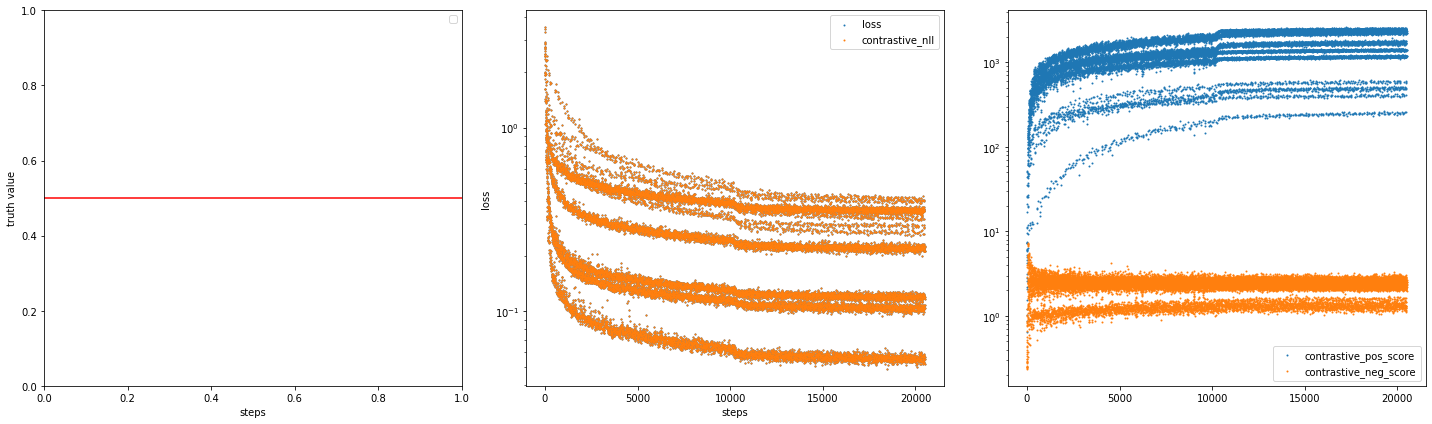

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    41.16  7.98  6.28 24.85 35.72  9.51  9.34 10.96  7.56  4.51  8.10  6.27  2.99  2.83      17.04      4.94
9     mrr    42.31  8.91  6.98 26.79 38.99 12.27 10.65 10.97  7.86  5.24  8.45  6.72  3.31  3.26      18.42      5.40
14    mrr    42.66  9.12  7.32 27.05 39.38 12.69 11.14 11.06  7.89  5.73  8.54  7.03  3.39  3.47      18.70      5.63
19    mrr    42.66  9.53  7.59 27.86 40.59 14.01 11.55 11.08  8.05  5.69  8.50  6.97  3.53  3.58      19.21      5.66
24    mrr    43.12  9.66  7.74 28.46 41.50 14.48 11.90 11.14  8.13  6.27  8.93  7.06  3.58  3.88      19.57      5.94
29    mrr    43.27  9.83  7.84 28.92 42.04 15.15 12.22 11.22  8.19  6.20  9.02  7.06

In [70]:
show_trajectory('log/fb15k-237/pretrain_complex1000-without-lift-and-tv/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


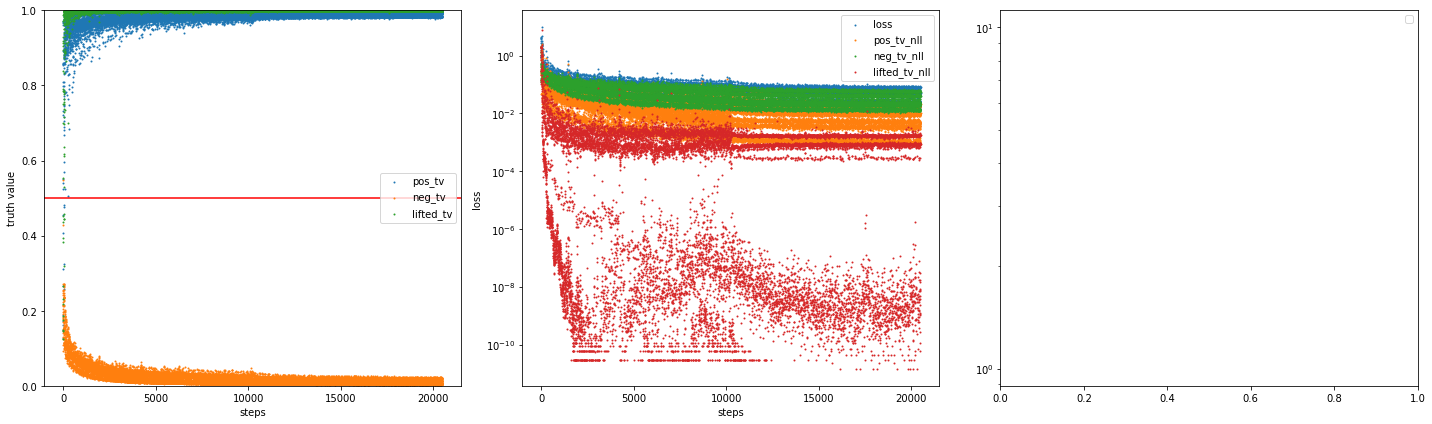

CQD evaluate valid
CQD evaluate test
tv evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    20.92  3.60  3.39  5.77  6.45  3.89  3.59  3.15  3.21  2.63  2.97  3.10  2.06  1.61       6.00      2.47
9     mrr    14.25  2.56  2.18  5.42  6.97  3.42  3.06  2.50  2.50  3.15  3.92  1.92  2.31  1.91       4.76      2.64
14    mrr    12.64  2.50  1.93  5.64  7.53  3.37  3.28  2.39  2.49  3.52  4.39  2.03  2.44  2.07       4.64      2.89
19    mrr    11.82  2.10  1.69  5.36  7.22  2.96  2.77  2.17  2.26  3.57  4.65  1.74  2.46  2.20       4.26      2.93
24    mrr    11.54  2.11  1.70  5.65  7.98  3.00  2.78  2.21  2.26  3.70  4.96  1.80  2.51  2.27       4.36      3.05
29    mrr    11.44  2.22  1.75  5.84  8.42  3.10  2.96  2.14  2.32  3.53  4.77  1.90  2.63  2.52       4.47      3.07
3

In [69]:
show_trajectory('log/fb15k-237/pretrain_complex1000-without-contrastive/output.log', metrics=['mrr'])

# No tricks

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


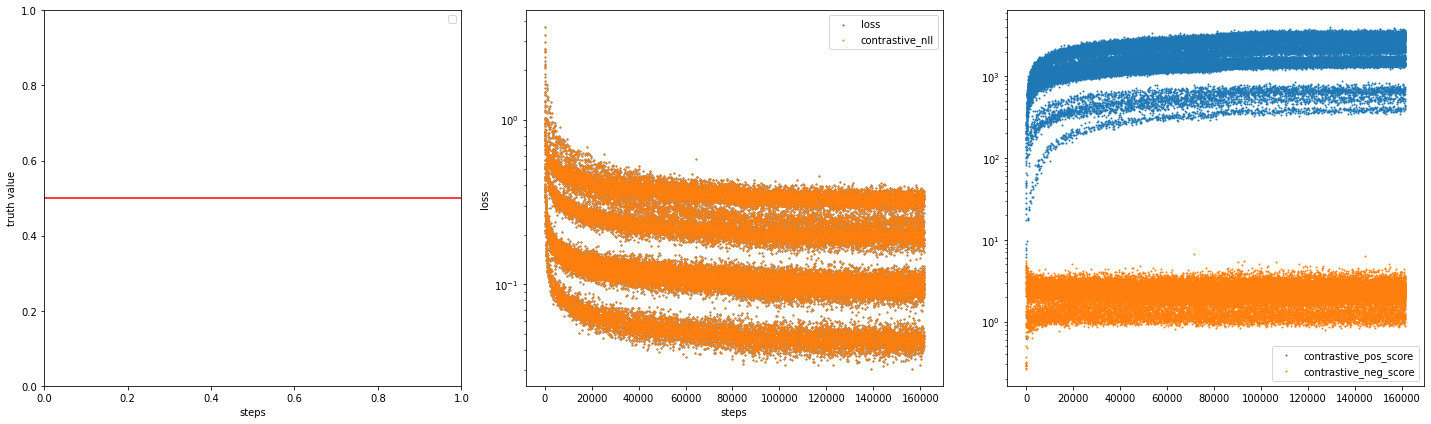

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    42.69  9.24  7.53 27.49 39.95 13.00 11.28 11.13  7.86  5.81  8.74  6.91  3.31  3.55      18.91      5.67
9     mrr    43.28  9.79  7.58 28.79 41.79 14.78 12.30 11.27  8.18  6.11  9.01  7.32  3.66  3.75      19.75      5.97
14    mrr    43.51  9.98  8.10 29.48 42.74 15.64 12.84 11.34  8.27  6.26  8.98  7.38  3.77  3.86      20.21      6.05
19    mrr    43.70 10.33  7.88 29.64 43.60 16.40 12.85 11.37  8.39  6.36  9.21  7.44  3.73  4.06      20.46      6.16
24    mrr    43.79 10.21  8.00 30.00 44.29 16.97 13.06 11.42  8.31  6.30  9.34  7.24  3.67  3.87      20.67      6.08
29    mrr    43.65 10.51  8.24 30.45 44.54 17.56 13.39 11.38  8.31  6.41  9.29  7.57

In [74]:
show_trajectory('log/fb15k-237/pretrain_complex1000-contrastive_nsize=32_batch_size=512/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


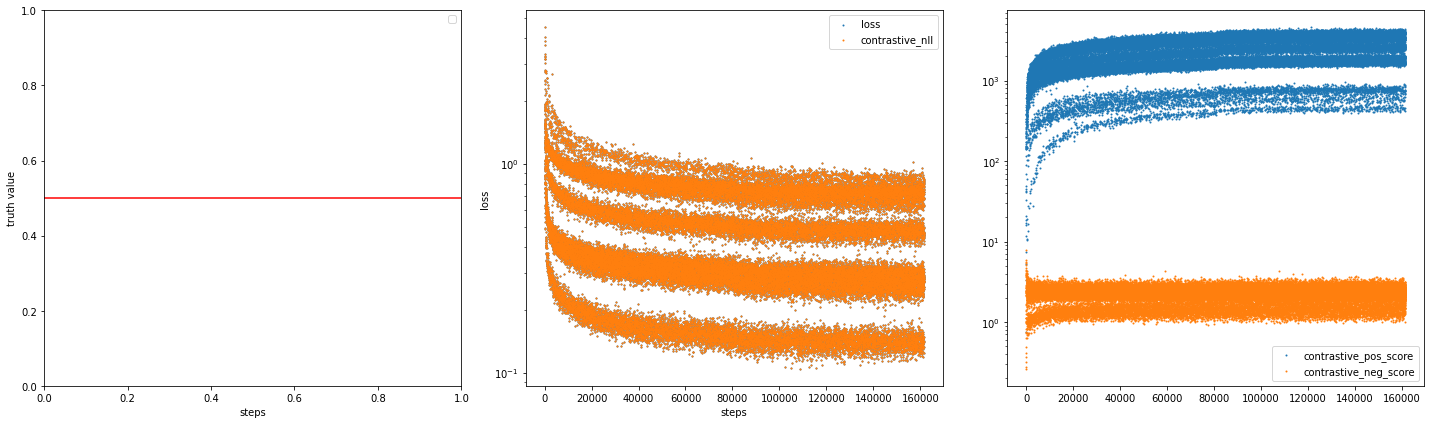

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    43.33  9.54  7.62 29.10 42.48 13.94 11.81 11.14  7.99  5.73  8.88  6.82  3.40  3.55      19.66      5.68
9     mrr    43.69  9.93  7.88 29.83 43.81 16.29 12.59 11.20  8.11  6.14  9.29  7.07  3.64  3.83      20.37      5.99
14    mrr    43.82 10.11  8.00 30.25 44.56 16.77 13.08 11.39  8.16  6.29  9.34  7.33  3.75  3.87      20.68      6.11
19    mrr    43.95 10.50  8.09 30.55 45.16 17.80 13.35 11.26  8.29  6.35  9.50  7.48  3.64  4.08      20.99      6.21
24    mrr    43.87 10.52  8.30 30.86 45.39 18.63 13.58 11.30  8.40  6.33  9.50  7.51  3.80  4.14      21.21      6.26
29    mrr    43.80 10.46  8.32 30.95 45.48 18.54 13.58 11.18  8.37  6.29  9.68  7.67

In [72]:
show_trajectory('log/fb15k-237/pretrain_complex1000-contrastive_nsize=128_batch_size=512/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


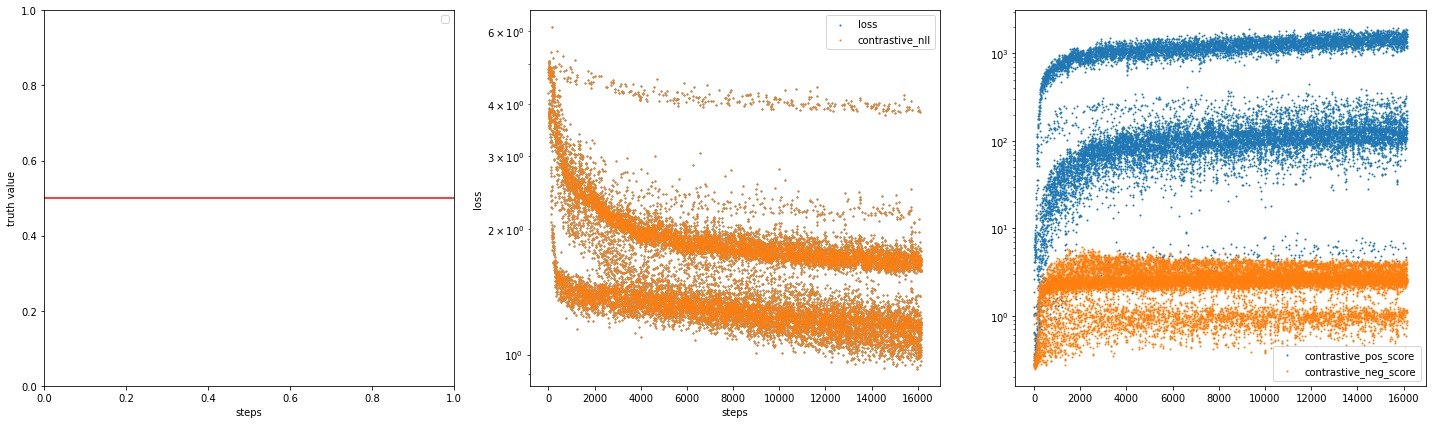

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    25.06  6.18  6.00  6.62  6.87  7.10  5.82  6.56  5.91  1.59  3.15  5.93  2.25  2.95       8.46      3.17
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    25.90  7.00  7.05  7.72  7.58  8.37  6.94  8.46  6.49  2.48  3.84  5.61  2.49  3.46       9.50      3.57


In [85]:
show_trajectory('log/fb15k-237/pretrain_complex1000-corrected-lmpgnn-contrastive_nsize=128_batch_size=512/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


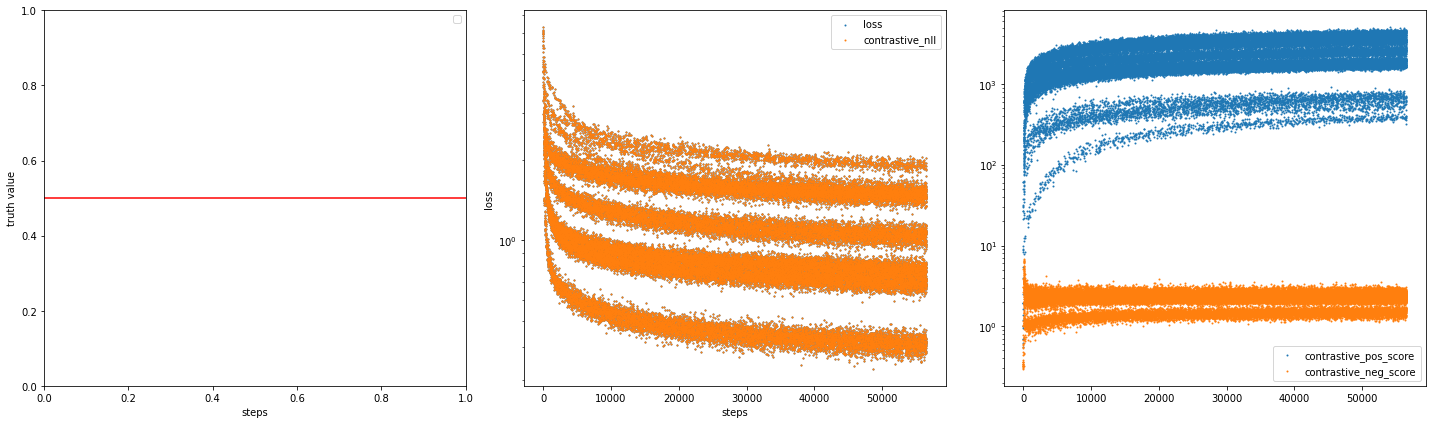

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    43.54  9.67  7.44 29.80 43.42 14.52 12.29 11.28  8.11  5.78  9.06  7.01  3.70  3.83      20.01      5.87
9     mrr    43.89 10.16  7.92 30.70 45.06 16.99 13.10 11.21  8.06  6.25  9.36  7.16  3.52  4.07      20.79      6.07
14    mrr    43.91 10.34  8.03 30.88 45.70 18.18 13.59 11.30  8.28  6.23  9.62  7.46  3.76  4.17      21.13      6.25
19    mrr    43.97 10.42  8.01 30.99 45.67 18.67 13.66 11.22  8.19  6.34  9.73  7.42  3.79  4.10      21.20      6.28
24    mrr    43.80 10.62  8.22 31.10 46.32 18.97 13.80 11.29  8.35  6.35  9.91  7.57  3.97  4.33      21.39      6.43
29    mrr    43.91 10.52  8.27 31.22 46.55 19.31 14.07 11.28  8.38  6.62  9.83  7.41

In [82]:
show_trajectory('log/fb15k-237/pretrain_complex1000-contrastive_nsize=512_batch_size=512/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


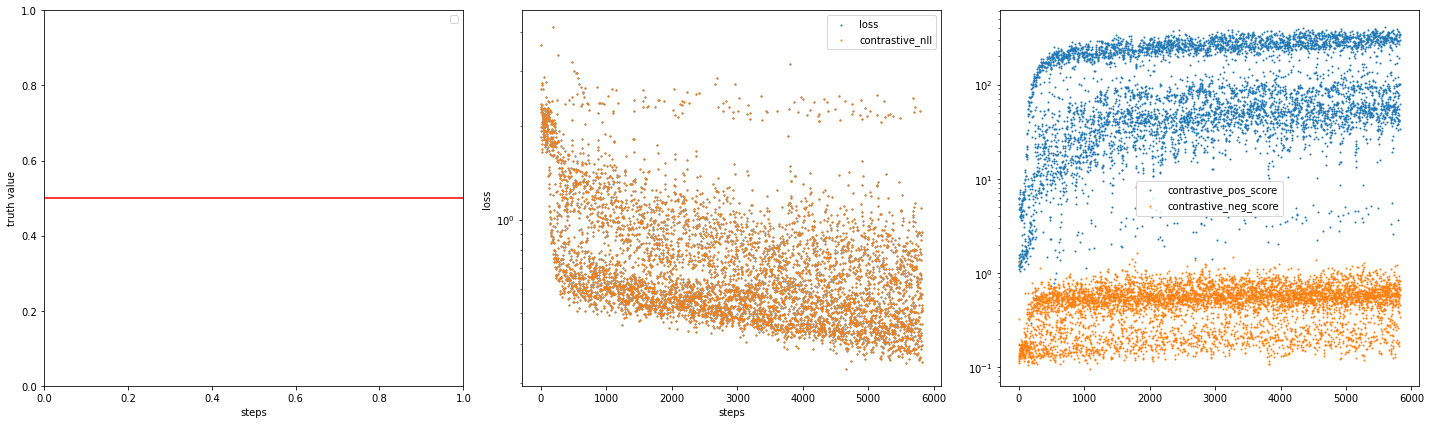

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    18.95  6.27  7.17  6.52  7.90  6.34  6.82  5.40  6.09  0.76  4.26  9.43  3.12  3.53       7.94      4.22
NN evaluate test


In [81]:
show_trajectory('log/nell/pretrain_complex1000-contrastive_nsize=32_batch_size=512/output.log', metrics=['mrr'])

In [37]:
show_trajectory('results/cqd-FB15k-237/output.log', metrics=['mrr'])

show_trajectory('results/cqd-FB15k/output.log', metrics=['mrr'])

CQD evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
-1    mrr    44.74  8.61  5.69 19.88 28.23 19.82 13.01 11.28  7.30  0.09  0.13  1.87  0.09  4.35      17.62      1.31


FileNotFoundError: [Errno 2] No such file or directory: 'results/unnamed/CQD evaluate valid.csv'

# Visualize Effects of eps

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


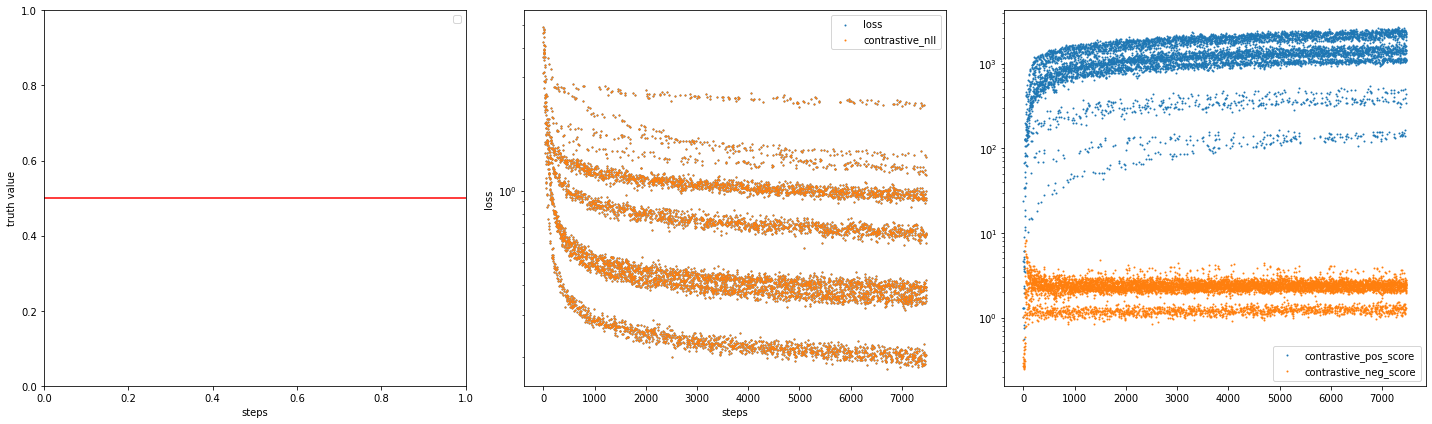

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    43.39  9.45  7.48 29.13 42.38  7.85 11.65 11.04  7.84  5.94  9.13  7.03  2.87  1.90      18.91      5.37
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    45.12 11.26  8.86 31.74 44.08  9.48 14.80 13.80  9.58  8.20 11.02  6.59  3.07  2.23      20.97      6.22


In [18]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


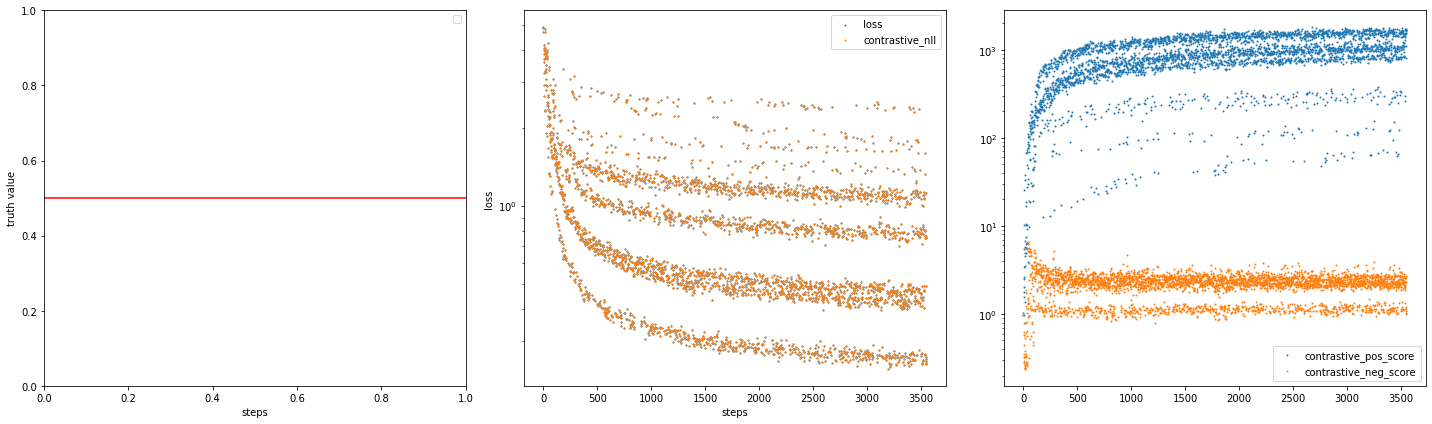

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
NN evaluate test


In [27]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.01/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


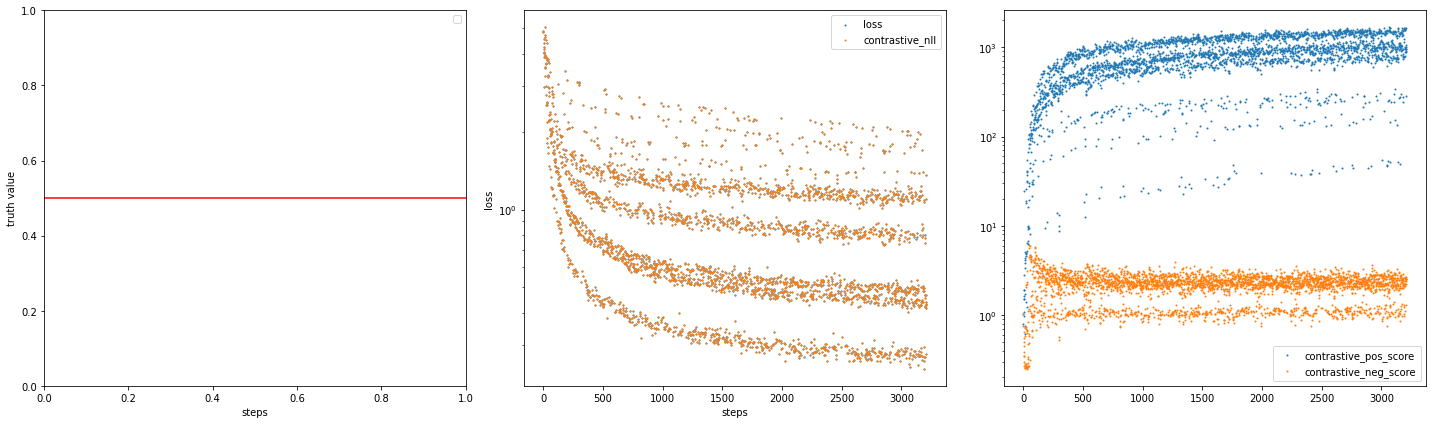

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
NN evaluate test


In [28]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.05/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


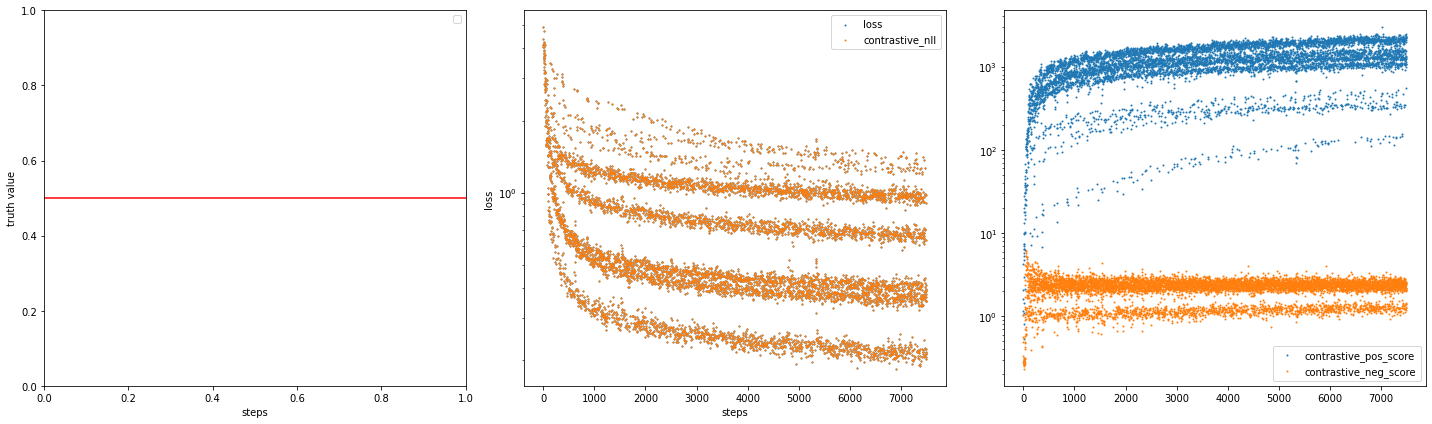

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    43.10  9.41  7.41 28.76 41.75 13.95 11.68 11.16  7.98  5.52  8.83  6.81  3.59  3.52      19.47      5.66
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    44.90 11.27  8.83 31.76 43.76 16.05 14.94 14.04  9.80  7.80 10.81  6.40  3.73  4.52      21.71      6.65


In [17]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.1/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


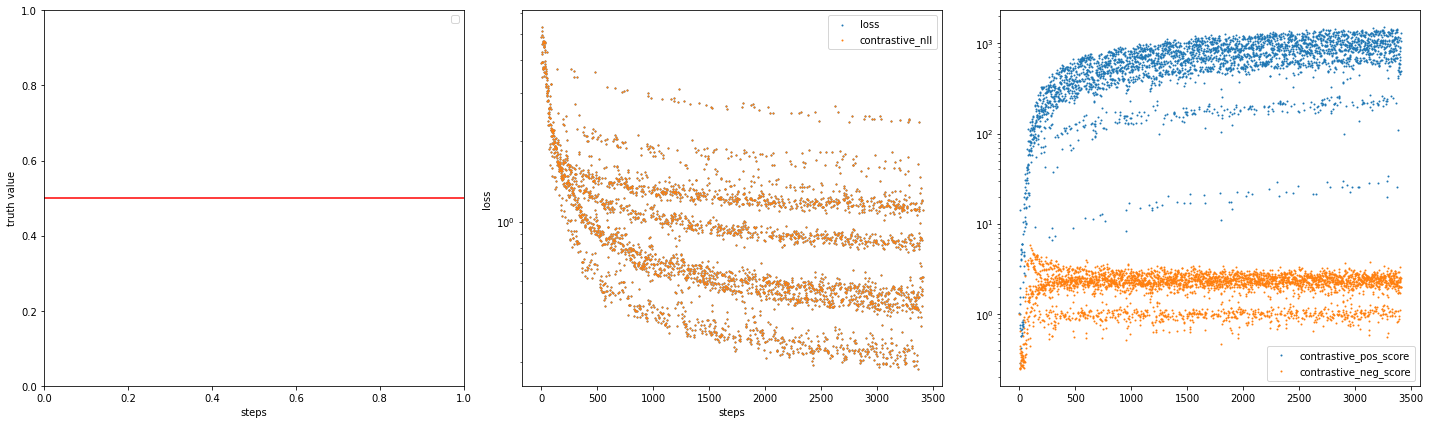

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
NN evaluate test


In [29]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.2/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


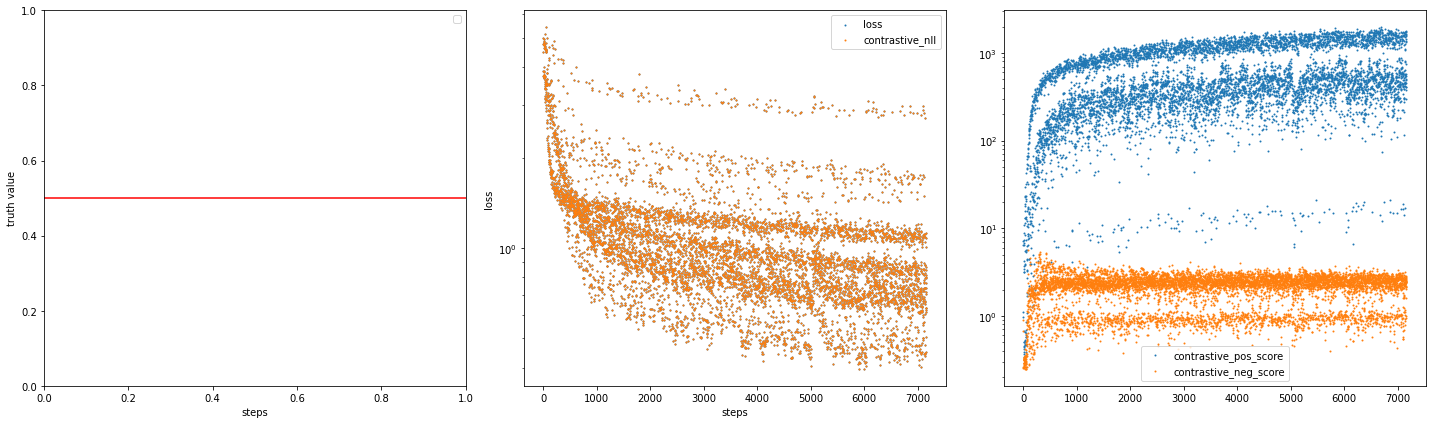

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    39.67  7.79  6.22 22.05 31.42 10.42  8.08 10.64  7.04  4.08  7.29  6.28  2.93  3.57      15.93      4.83
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    41.22  8.90  7.54 25.02 33.14 12.00 10.04 13.36  8.32  5.42  8.71  5.92  3.02  4.91      17.73      5.60


In [19]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_0.5/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


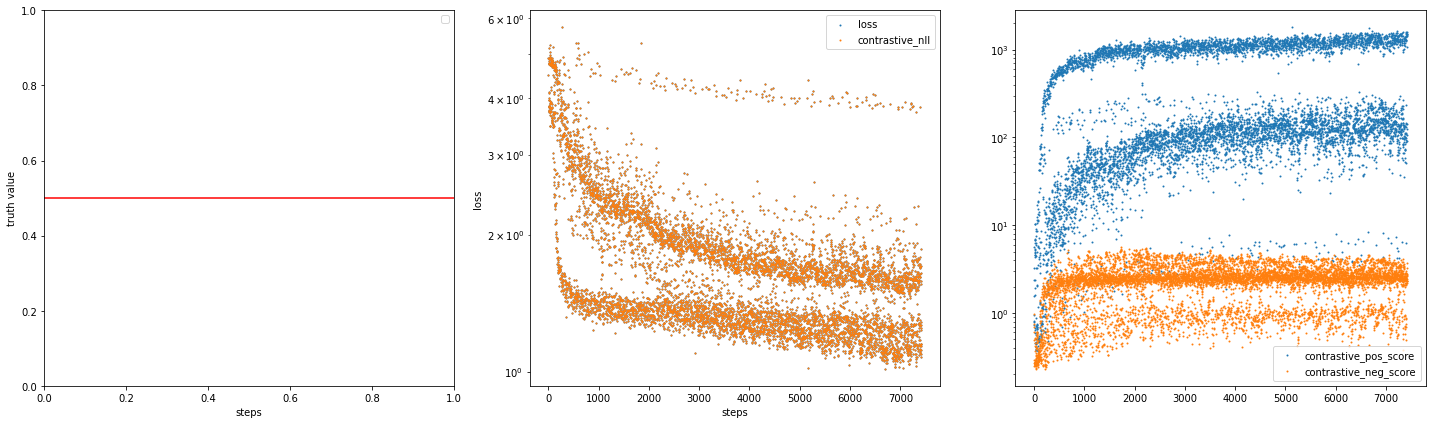

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    26.02  6.09  5.86  7.13  7.72  6.33  5.75  7.02  5.67  1.69  3.37  6.02  2.39  2.67       8.62      3.23
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    26.97  6.91  7.02  8.46  8.42  7.43  6.83  9.19  6.41  2.62  4.17  5.50  2.70  3.21       9.74      3.64


In [21]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_1/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


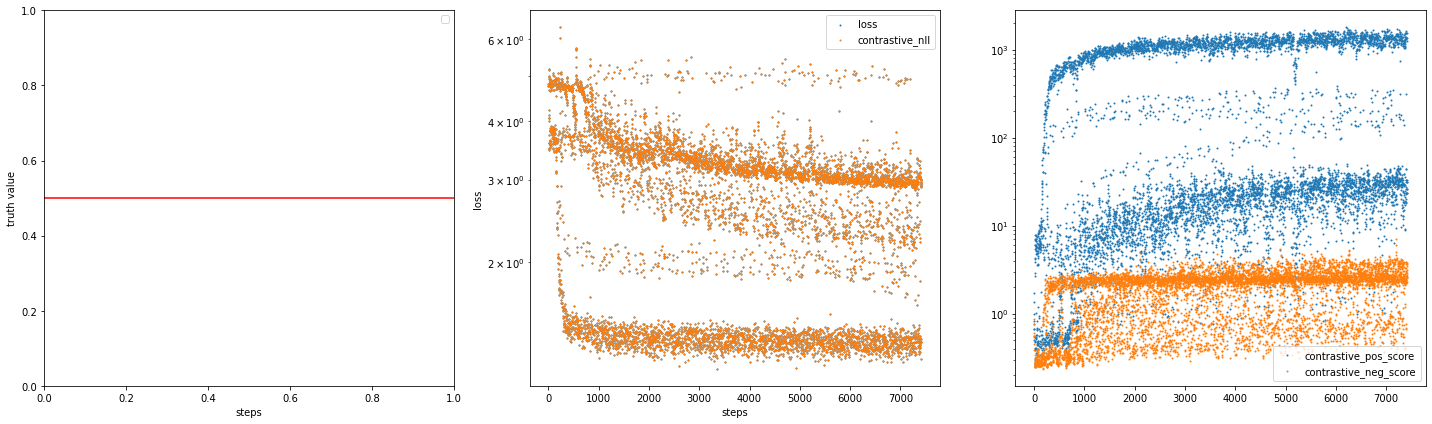

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr     6.14  5.71  5.70  1.18  0.96  4.32  5.21  1.14  5.40  0.11  0.41  6.04  2.31  1.47       3.97      2.07
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr     6.26  6.62  6.71  1.32  1.14  5.21  6.28  1.47  5.96  0.16  0.51  5.38  2.57  1.58       4.55      2.04


In [22]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-eps_2/output.log', metrics=['mrr'])

# Visualize Temp

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


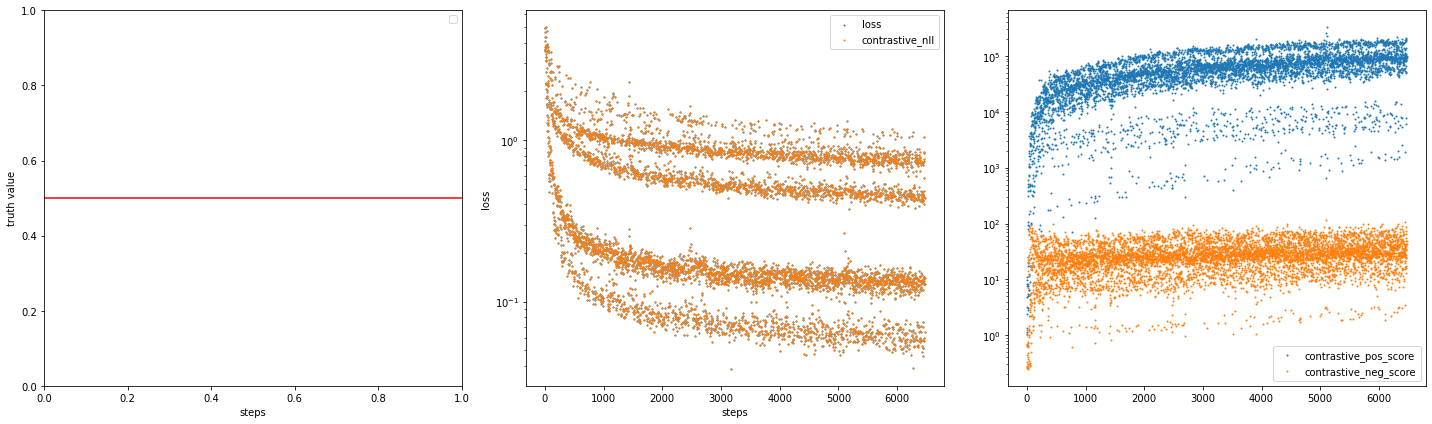

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    43.21  9.30  7.31 28.48 41.98 12.94 11.25 10.90  8.15  5.04  9.32  6.59  3.53  3.50      19.28      5.59
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    44.73 10.22  8.33 31.31 43.67 14.24 13.73 13.57  9.59  6.63 10.91  6.32  3.69  4.33      21.04      6.37


In [23]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_0.05/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


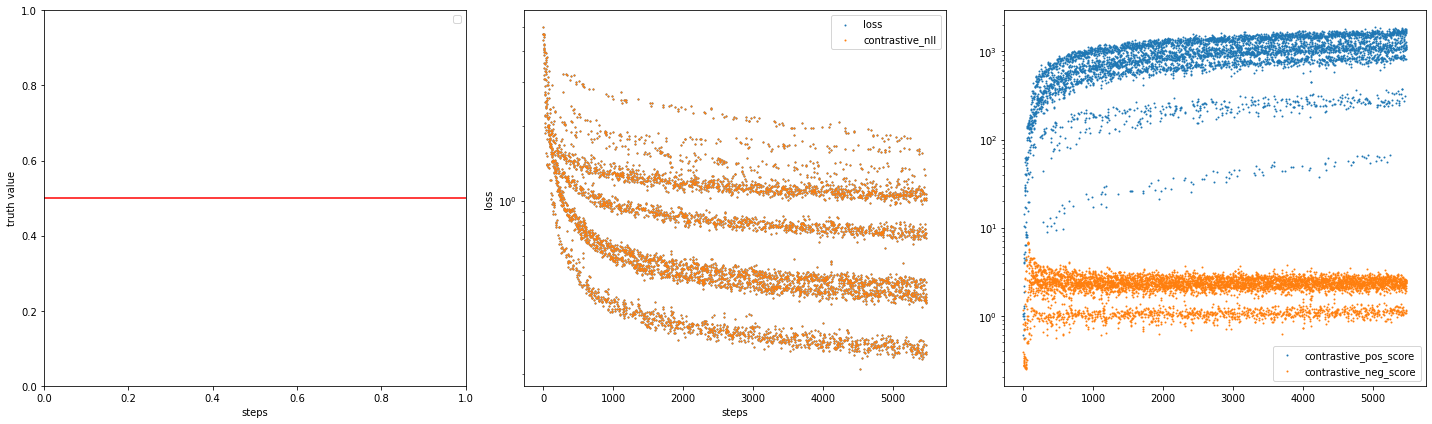

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    43.10  9.19  7.25 28.07 40.85 13.71 11.21 11.06  7.93  5.36  8.61  6.80  3.48  3.58      19.15      5.57
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    44.82 10.97  8.67 31.18 42.36 15.63 14.32 13.97  9.53  7.30 10.41  6.26  3.75  4.74      21.27      6.49


In [24]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_0.1/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


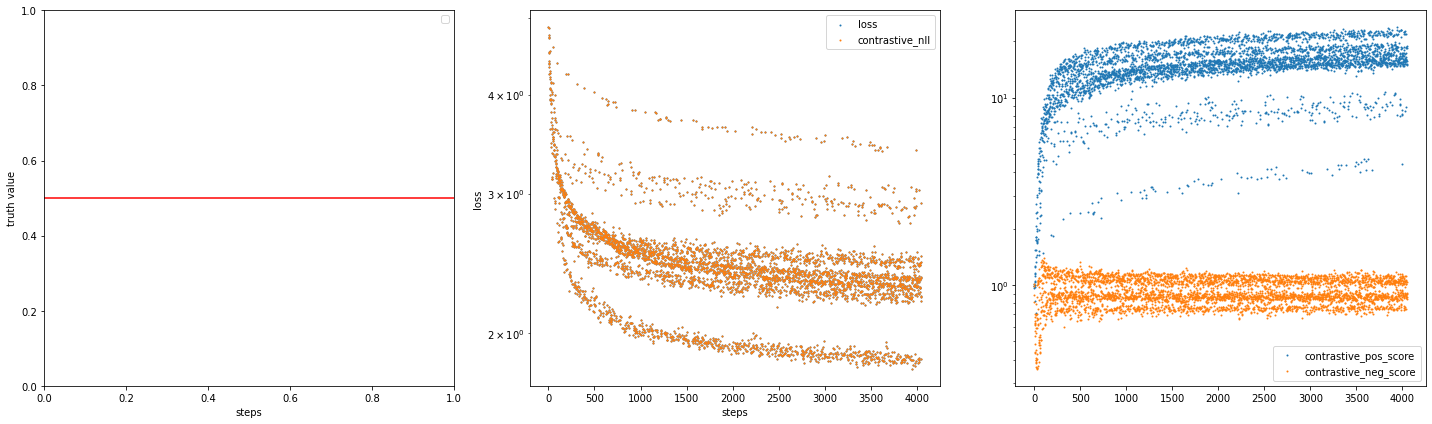

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
NN evaluate test


In [30]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_0.25/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


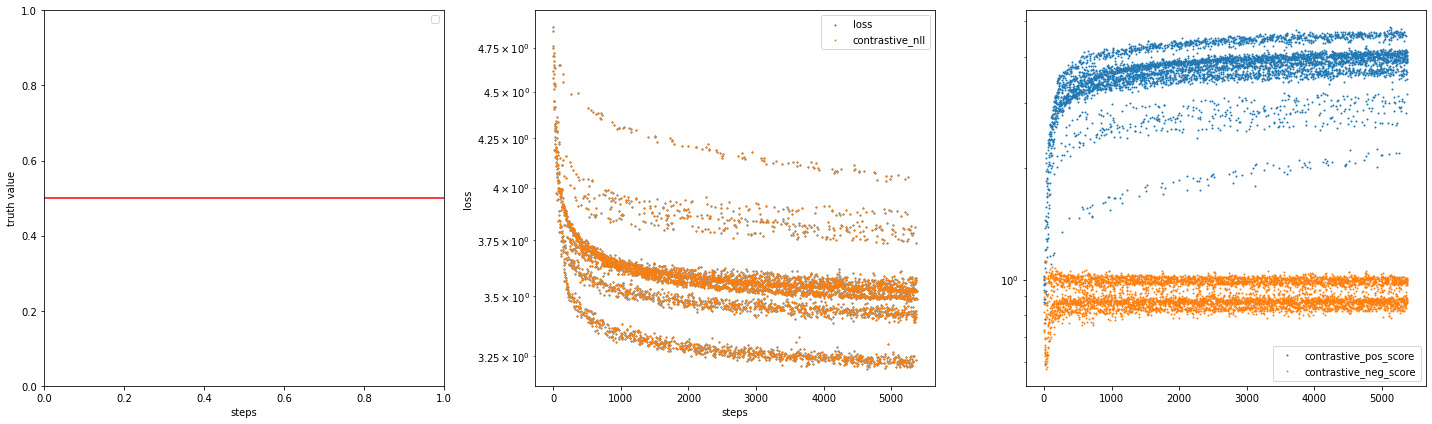

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    41.01  8.25  6.21 24.74 34.84 11.32  9.97 10.63  7.09  4.93  7.43  5.90  3.08  3.21      17.12      4.91
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    42.76 10.17  7.75 27.33 36.45 12.86 12.93 13.19  8.71  6.73  8.87  5.51  3.25  4.25      19.13      5.72


In [25]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_0.5/output.log', metrics=['mrr'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


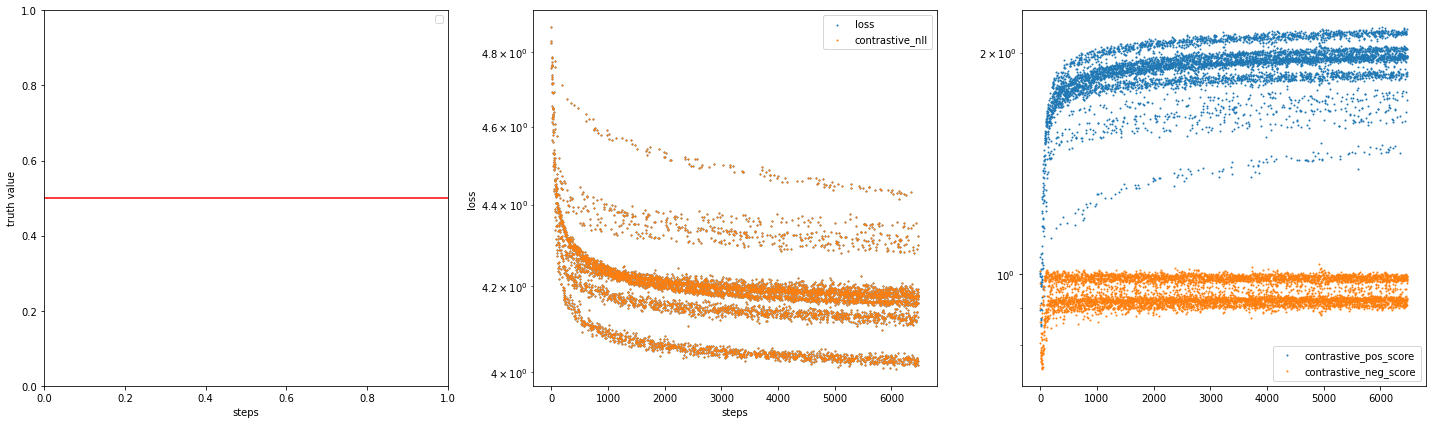

CQD evaluate valid
CQD evaluate test
tv evaluate valid
tv evaluate test
NN evaluate valid
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    41.00  8.21  6.20 24.64 34.69 11.02  9.90 10.59  7.09  4.88  7.39  5.95  3.05  3.20      17.04      4.89
NN evaluate test
                1p    2p    3p    2i    3i    pi    ip    2u    up   2in   3in   inp   pin   pni  epfo mean  Neg mean
epoch metric                                                                                                         
4     mrr    42.70 10.16  7.77 27.02 36.29 12.40 12.81 13.09  8.50  6.58  8.80  5.49  3.25  4.13      18.97      5.65


In [26]:
show_trajectory('log/FB15k-237/lmpnn-complex1k-temp_1/output.log', metrics=['mrr'])